# Botryllus brain analysis1
By: Atefe Rostami

# Packages

In [1]:
import warnings
import random
warnings.simplefilter(action = "ignore", category = FutureWarning)
import numpy as np
import pandas as pd
# import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from igraph import *
import csv
from igraph import *
# from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_text
# import bbknn
# import leidenalg
import seaborn as sns
#from gprofiler import GProfiler

from anndata import AnnData

import plotly.graph_objects as go
import plotly.offline as pyo


In [2]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", mpl.__version__)
print("seaborn version:", sns.__version__)


numpy version: 2.2.6
pandas version: 2.2.3
matplotlib version: 3.10.3
seaborn version: 0.13.2


In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Initial data import


In [4]:
# Load the dataset
df = pd.read_csv('Brain_scRNA_Dec_2023_BRAIN_Counts_Table.csv')
df

,GI,Gene_Name,Gene_Note,Aligned_PAC4_Plate3_O06_ILW105_Brain_AB_Zooid_small_3_p09c11r08_6941c_13_19_months_S863.out.counts.txt,Aligned_PAC4_Plate3_M02_ILW104_Brain_AB_Zooid_small_2_p09c05r03_6941c_13_19_months_S797.out.counts.txt,Aligned_PAC4_Plate2_M16_ILW103_Brain_AB_Zooid_large_3_p07c01r06_6941c_13_19_months_S637.out.counts.txt,Aligned_PAC4_Plate2_K15_ILW102_Brain_B2_Zooid_large_2_p07c07r04_6941c_13_19_months_S619.out.counts.txt,Aligned_PAC4_Plate3_G11_ILW106_Brain_AB_Zooid_large_4_p10c11r06_6941c_13_19_months_S935.out.counts.txt,Aligned_PAC4_Plate2_O09_ILW101_Brain_B2_Zooid_large_1_p06c11r04_6941c_1_19_months_S527.out.counts.txt,Aligned_PAC4_Plate3_G08_ILW105_Brain_AB_Zooid_small_3_p10c11r02_6941c_13_19_months_S887.out.counts.txt,...,Aligned_PAC4_Plate2_L11_ILW102_Brain_B2_Zooid_large_2_p06c04r07_6941c_1_19_months_S556.out.counts.txt,Aligned_PAC4_Plate3_B12_ILW106_Brain_AB_Zooid_large_4_p10c10r07_6941c_13_19_months_S946.out.counts.txt,Aligned_PAC4_Plate2_I23_ILW104_Brain_AB_Zooid_small_2_p08c01r07_6941c_13_19_months_S745.out.counts.txt,Aligned_PAC4_Plate2_N07_ILW101_Brain_B2_Zooid_large_1_p06c02r02_6941c_1_19_months_S494.out.counts.txt,Aligned_PAC4_Plate2_L18_ILW103_Brain_AB_Zooid_large_3_p07c08r08_6941c_13_19_months_S668.out.counts.txt,Aligned_PAC4_Plate2_O07_ILW101_Brain_B2_Zooid_large_1_p06c03r02_6941c_1_19_months_S495.out.counts.txt,Aligned_PAC4_Plate2_P04_ILW100_Brain_B2_Zooid_small_1_p05c04r06_6941c_1_19_months_S448.out.counts.txt,Aligned_PAC4_Plate3_N12_ILW106_Brain_AB_Zooid_large_4_p10c10r08_6941c_13_19_months_S958.out.counts.txt,Aligned_PAC4_Plate2_F22_ILW103_Brain_AB_Zooid_large_3_p08c06r05_6941c_13_19_months_S726.out.counts.txt,Aligned_PAC4_Plate3_G14_ILW106_Brain_AB_Zooid_large_4_p11c11r02_6941c_13_19_months_S983.out.counts.txt
0,g1,g1,g1|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g10,g10,g10|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,g100,Klhl10,Kelch-like protein 10 [Mus musculus],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,g1000,WDR19,WD repeat-containing protein 19 [Homo sapiens],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,g10000,g10000,g10000|introns:1|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72113,__no_feature,NaN,NaN,62,236947,169288,255,350440,2982,35889,...,18741,7537,1104,387400,87939,392462,15597,4041,21610,105402
72114,__ambiguous,NaN,NaN,0,2162,1735,0,3524,16,189,...,110,52,3,1987,795,1812,79,17,199,904
72115,__too_low_aQual,NaN,NaN,0,18,33,0,47,0,1,...,2,2,0,35,14,43,2,0,3,4
72116,__not_aligned,NaN,NaN,17873,330876,256172,48483,586055,9333,292376,...,26679,51094,12786,822342,136587,909838,36070,99680,272789,271757


# Pre_Processing

In [5]:
# Identify metadata columns (first three columns)
metadata_cols = df.columns[:3]
sample_cols = df.columns[3:]

new_column_names = []
for col in sample_cols:
    parts = col.split("_")  # Splitting by "_"

    try:
        sample_id = parts[4]  # ILWXYZ (Sample ID)
        region = parts[6]  # Region (B2, AB)

        # Ensure "19_months" is not split
        if len(parts) > 14 and parts[13].isdigit() and parts[14] == "months":
            age = f"{parts[13]}_{parts[14]}"  # "19_months"
            replicate = parts[10]  # Replicate (pXXcXXrXX)
            sample_number = parts[15]  # Sample Number (SXXX)
        else:
            age = "Unknown"  # If structure doesn't match, label as unknown
            replicate = parts[-3] if len(parts) > 4 else "Unknown"
            sample_number = parts[-2] if len(parts) > 3 else "Unknown"

        # Construct the new column name in the expected format
        new_col_name = f"{sample_id}-{region}-{age}-{replicate}-{sample_number}"
    except IndexError:
        new_col_name = col  # Keep original if unexpected format

    new_column_names.append(new_col_name)

# # rename g_unique column name to Gene_ID
# df.rename(columns={'g_unique': 'Gene_ID'}, inplace=True)
# # Ensure the first three columns are metadata
# metadata_cols = ['Gene_ID', 'Gene_Name', 'Gene_Description'] + list(metadata_cols[3:])
# Rename columns in DataFrame
df.columns = list(metadata_cols) + new_column_names
display(df.head())

,GI,Gene_Name,Gene_Note,ILW105-AB-19_months-p09c11r08-S863.out.counts.txt,ILW104-AB-19_months-p09c05r03-S797.out.counts.txt,ILW103-AB-19_months-p07c01r06-S637.out.counts.txt,ILW102-B2-19_months-p07c07r04-S619.out.counts.txt,ILW106-AB-19_months-p10c11r06-S935.out.counts.txt,ILW101-B2-19_months-p06c11r04-S527.out.counts.txt,ILW105-AB-19_months-p10c11r02-S887.out.counts.txt,...,ILW102-B2-19_months-p06c04r07-S556.out.counts.txt,ILW106-AB-19_months-p10c10r07-S946.out.counts.txt,ILW104-AB-19_months-p08c01r07-S745.out.counts.txt,ILW101-B2-19_months-p06c02r02-S494.out.counts.txt,ILW103-AB-19_months-p07c08r08-S668.out.counts.txt,ILW101-B2-19_months-p06c03r02-S495.out.counts.txt,ILW100-B2-19_months-p05c04r06-S448.out.counts.txt,ILW106-AB-19_months-p10c10r08-S958.out.counts.txt,ILW103-AB-19_months-p08c06r05-S726.out.counts.txt,ILW106-AB-19_months-p11c11r02-S983.out.counts.txt
0,g1,g1,g1|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g10,g10,g10|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,g100,Klhl10,Kelch-like protein 10 [Mus musculus],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,g1000,WDR19,WD repeat-containing protein 19 [Homo sapiens],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,g10000,g10000,g10000|introns:1|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Controlla i valori duplicati nelle colonne specificate
gi_duplicates = df['GI'].duplicated().any()
gene_name_duplicates = df['Gene_Name'].duplicated().any()
gene_note_duplicates = df['Gene_Note'].duplicated().any()

# Risultati
print(f"Duplicati in GI: {gi_duplicates}")
print(f"Duplicati in Gene_Name: {gene_name_duplicates}")
print(f"Duplicati in Gene_Note: {gene_note_duplicates}")

# Opzionalmente, puoi anche stampare i valori duplicati
# if gene_name_duplicates:
#     print("Valori duplicati in Gene_Name:")
#     print(df[df['Gene_Name'].duplicated(keep=False)].sort_values(by='Gene_Name'))


# Creazione della nuova colonna g_unique e metterla come prima colonna
df['g_unique'] = df['GI'].astype(str) + '_' + df['Gene_Name'].astype(str)
cols = df.columns.tolist()
print(cols[-1])
cols = cols[-1:] + cols[:-1]
df = df[cols]

# set GI as index
df.set_index('GI', inplace=True)
# remove "GI", the name of the index
df.index.name = None

# remove the rows which index does not start with "g" (eg. "g1")
df_cleaned = df[df.index.str.startswith('g')]

df_cleaned.tail()


Duplicati in GI: False
Duplicati in Gene_Name: True
Duplicati in Gene_Note: True
g_unique


,g_unique,Gene_Name,Gene_Note,ILW105-AB-19_months-p09c11r08-S863.out.counts.txt,ILW104-AB-19_months-p09c05r03-S797.out.counts.txt,ILW103-AB-19_months-p07c01r06-S637.out.counts.txt,ILW102-B2-19_months-p07c07r04-S619.out.counts.txt,ILW106-AB-19_months-p10c11r06-S935.out.counts.txt,ILW101-B2-19_months-p06c11r04-S527.out.counts.txt,ILW105-AB-19_months-p10c11r02-S887.out.counts.txt,...,ILW102-B2-19_months-p06c04r07-S556.out.counts.txt,ILW106-AB-19_months-p10c10r07-S946.out.counts.txt,ILW104-AB-19_months-p08c01r07-S745.out.counts.txt,ILW101-B2-19_months-p06c02r02-S494.out.counts.txt,ILW103-AB-19_months-p07c08r08-S668.out.counts.txt,ILW101-B2-19_months-p06c03r02-S495.out.counts.txt,ILW100-B2-19_months-p05c04r06-S448.out.counts.txt,ILW106-AB-19_months-p10c10r08-S958.out.counts.txt,ILW103-AB-19_months-p08c06r05-S726.out.counts.txt,ILW106-AB-19_months-p11c11r02-S983.out.counts.txt
g9995,g9995_g9995,g9995,g9995|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9996,g9996_g9996,g9996,g9996|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9997,g9997_g9997,g9997,g9997|introns:2|%transcript_support:20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9998,g9998_WARS,WARS,"Tryptophan--tRNA ligase, cytoplasmic [Homo sa...",0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
g9999,g9999_g9999,g9999,g9999|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**df_sel** is the cleaned input dataset. Ready for more processing

In [7]:
df_cleaned.columns
# save a new df without Gene_Note and Gene_Name columns
df_sel = df_cleaned.drop(['Gene_Note', 'Gene_Name'], axis=1)

df_sel.set_index('g_unique', inplace=True)
df_sel.index.name = None

df_sel.tail()

,ILW105-AB-19_months-p09c11r08-S863.out.counts.txt,ILW104-AB-19_months-p09c05r03-S797.out.counts.txt,ILW103-AB-19_months-p07c01r06-S637.out.counts.txt,ILW102-B2-19_months-p07c07r04-S619.out.counts.txt,ILW106-AB-19_months-p10c11r06-S935.out.counts.txt,ILW101-B2-19_months-p06c11r04-S527.out.counts.txt,ILW105-AB-19_months-p10c11r02-S887.out.counts.txt,ILW103-AB-19_months-p07c06r07-S654.out.counts.txt,ILW106-AB-19_months-p11c12r04-S1008.out.counts.txt,ILW101-B2-19_months-p06c09r01-S489.out.counts.txt,...,ILW102-B2-19_months-p06c04r07-S556.out.counts.txt,ILW106-AB-19_months-p10c10r07-S946.out.counts.txt,ILW104-AB-19_months-p08c01r07-S745.out.counts.txt,ILW101-B2-19_months-p06c02r02-S494.out.counts.txt,ILW103-AB-19_months-p07c08r08-S668.out.counts.txt,ILW101-B2-19_months-p06c03r02-S495.out.counts.txt,ILW100-B2-19_months-p05c04r06-S448.out.counts.txt,ILW106-AB-19_months-p10c10r08-S958.out.counts.txt,ILW103-AB-19_months-p08c06r05-S726.out.counts.txt,ILW106-AB-19_months-p11c11r02-S983.out.counts.txt
g9995_g9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9996_g9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9997_g9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9998_WARS,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9999_g9999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# print the removed rows
print("Removed rows:")
df_removed = df[~df.index.str.startswith('g')]
df_removed.index

Removed rows:


Index(['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned',
       '__alignment_not_unique'],
      dtype='object')

## AnnData

In [9]:
# adata = AnnData(df_sel)
# Transpose the DataFrame to have genes as rows and cells as columns
# obs is the cell/sample IDs
# var is the gene IDs/names
adata = AnnData(X=df_sel.T.values, obs=pd.DataFrame(index=df_sel.columns), var=pd.DataFrame(index=df_sel.index))

# print first 4 row names and first 4 column names
print(adata.obs_names[:4])  # First 4 cell/sample IDs
print(adata.var_names[:4])  # First 4 gene IDs/names
print(adata.shape)          # Shape: (cells, genes)


Index(['ILW105-AB-19_months-p09c11r08-S863.out.counts.txt',
       'ILW104-AB-19_months-p09c05r03-S797.out.counts.txt',
       'ILW103-AB-19_months-p07c01r06-S637.out.counts.txt',
       'ILW102-B2-19_months-p07c07r04-S619.out.counts.txt'],
      dtype='object')
Index(['g1_g1', 'g10_g10', 'g100_Klhl10', 'g1000_WDR19'], dtype='object')
(683, 72113)


In [10]:
import scipy.sparse

print(type(adata.X))

# Or check if it's sparse
if scipy.sparse.issparse(adata.X):
    print("adata.X is a sparse matrix.")
else:
    print("adata.X is a dense NumPy array.")


<class 'numpy.ndarray'>
adata.X is a dense NumPy array.


adata.X is your expression matrix (cells × genes).

.sum(axis=1) sums counts across all genes for each cell, giving the total counts per cell.


In [11]:
# Parse sample metadata from cell/sample names and store as separate columns in adata.obs
# Extracts Sample_ID, Region, Age, Replicate, and Sample_Number from the sample name string
adata.obs['Sample_ID'] = [i.split('-')[0] for i in adata.obs_names] 
adata.obs['Region'] =    [i.split('-')[1] for i in adata.obs_names]
adata.obs['Age'] =       [i.split('-')[2] for i in adata.obs_names]
adata.obs['Replicate'] = [i.split('-')[3] for i in adata.obs_names]
adata.obs['Sample_Number'] = [i.split('-')[4] for i in adata.obs_names]

print(adata.shape)


(683, 72113)


**Check** the format of the matrix

In [12]:
# Sum along the columns (genes)
# adata.X is a sparse matrix, so we need to convert it to a dense format first
total_counts = adata.X.sum(axis=1)
print(total_counts.shape)

(683,)


## Quality control

In [13]:
import scanpy as sc 
adata.obs['n_counts'] = adata.X.sum(1) # total counts per cell
adata.obs['n_genes'] = (adata.X > 0).sum(1) # number of expressed genes per cell
adata = adata[adata.obs['n_counts']>=100]
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)
adata_qc = adata[adata.obs.n_counts >= 100, :].copy()  # Keep your 581 cells
adata_qc = adata_qc[:, adata_qc.var.n_cells >= 10].copy()  # Keep your 14,658 genes


/home/pissmaster/Desktop/botryllus brain analysis2/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [14]:
print(adata_qc.shape)

(573, 21004)


# Normalization

## LogNorm

It adjusts for sequencing depth differences across cells — like converting all cells to the same "library size."

Think of it like converting raw counts to counts per 10,000 (CP10K), similar to CPM (counts per million).

In [15]:
sc.pp.normalize_total(adata_qc, target_sum=1e4)
sc.pp.log1p(adata_qc)

# PCA

In [16]:
sc.pp.highly_variable_genes(adata_qc, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_qc.raw = adata_qc
adata_qc = adata_qc[:, adata_qc.var.highly_variable]

In [17]:
# print adata_qc shape
print(f"adata_qc shape: {adata_qc.shape}")

adata_qc shape: (573, 6020)


In [18]:
sc.pp.scale(adata_qc, max_value=10)
sc.tl.pca(adata_qc, svd_solver='arpack')


/home/pissmaster/Desktop/botryllus brain analysis2/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning:

Received a view of an AnnData. Making a copy.



In [19]:
print(adata_qc.shape)

(573, 6020)


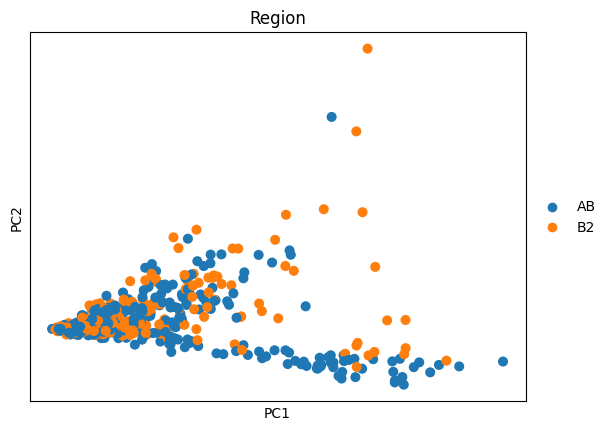

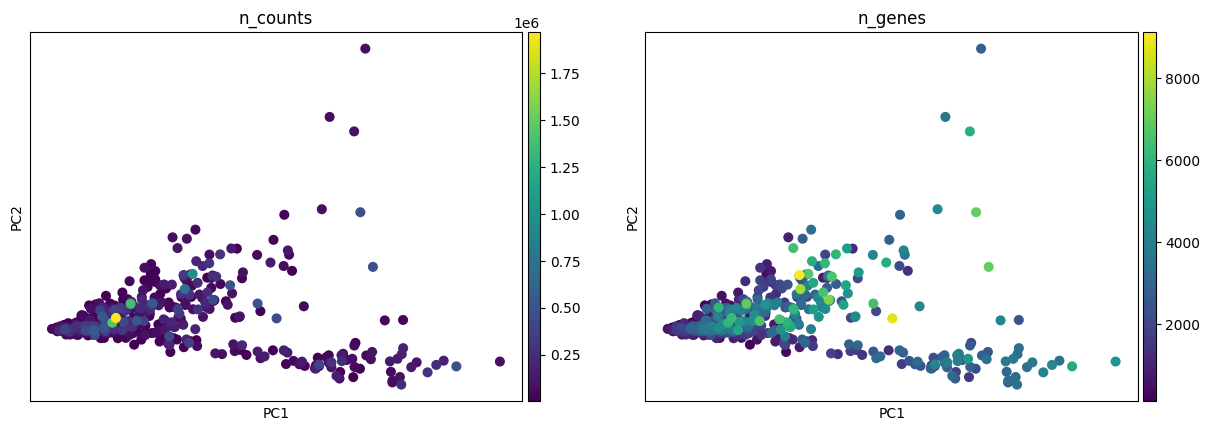

In [20]:
sc.pl.pca(adata_qc, color=['Region'])

# Plot PCA with n_counts and n_genes
sc.pl.pca_scatter(adata_qc, color=['n_counts', 'n_genes'])

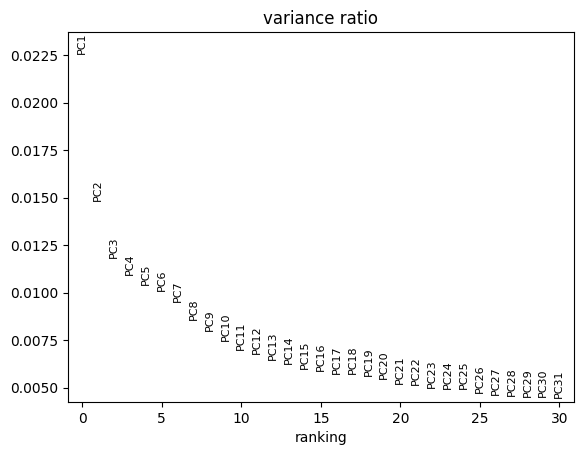

In [21]:
# pca variance ratio
sc.pl.pca_variance_ratio(adata_qc, log=False)



/tmp/ipykernel_171190/2878490838.py:22: DeprecationWarning:

Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)



=== Optimal PC Number Selection ===
Knee point method: PC11
Variance threshold method (1%): PC7
Cumulative variance method (80%): PC50


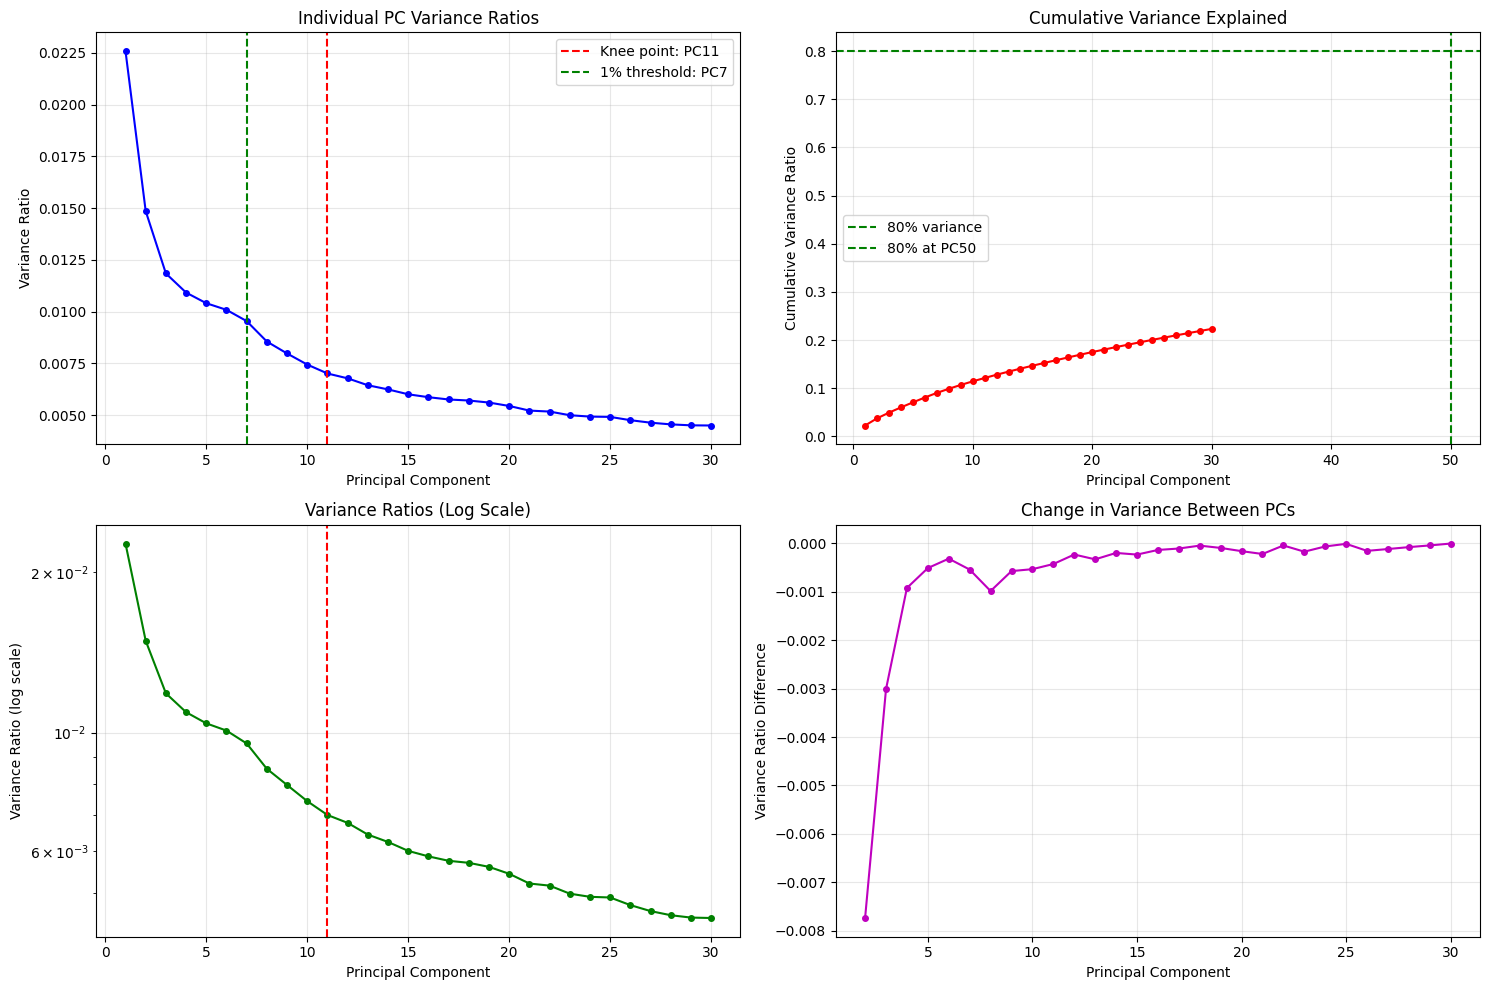


PC Selection Recommendations:
                   Method  Recommended_PCs Variance_Captured                Use_Case
     Knee Point Detection               11             12.1%         Balanced choice
  Variance Threshold (1%)                7              9.0% Remove noise components
Cumulative Variance (80%)               50             30.4%  Comprehensive analysis
      Conservative Choice                7              9.0%    Minimize overfitting
        Aggressive Choice               11             12.1%  Capture more variation

*** FINAL RECOMMENDATION: Use PC1-PC11 for downstream analysis ***
This captures 12.1% of total variance


In [22]:
# 1. Calculate cumulative variance explained
variance_ratio = adata_qc.uns['pca']['variance_ratio']
cumulative_variance = np.cumsum(variance_ratio)

# 2. Find elbow point using different methods
def find_elbow_point(variance_ratios, method='knee'):
    """Find elbow point in variance curve"""
    if method == 'knee':
        # Knee point detection
        n_components = len(variance_ratios)
        x = np.arange(n_components)
        y = variance_ratios
        
        # Line from first to last point
        line_start = np.array([x[0], y[0]])
        line_end = np.array([x[-1], y[-1]])
        
        # Calculate distances from each point to the line
        distances = []
        for i in range(n_components):
            point = np.array([x[i], y[i]])
            distance = np.abs(np.cross(line_end - line_start, line_start - point)) / np.linalg.norm(line_end - line_start)
            distances.append(distance)
        
        elbow_idx = np.argmax(distances)
        return elbow_idx + 1  # +1 because we want PC number, not index
    
    elif method == 'threshold':
        # Find where variance drops below threshold
        for i, var in enumerate(variance_ratios):
            if var < 0.01:  # 1% threshold
                return i + 1
        return len(variance_ratios)
    
    elif method == 'cumulative':
        # Find where cumulative variance reaches threshold
        cumulative = np.cumsum(variance_ratios)
        for i, cum_var in enumerate(cumulative):
            if cum_var > 0.8:  # 80% threshold
                return i + 1
        return len(variance_ratios)

# 3. Apply different elbow detection methods
elbow_knee = find_elbow_point(variance_ratio, 'knee')
elbow_threshold = find_elbow_point(variance_ratio, 'threshold')
elbow_cumulative = find_elbow_point(variance_ratio, 'cumulative')

print("=== Optimal PC Number Selection ===")
print(f"Knee point method: PC{elbow_knee}")
print(f"Variance threshold method (1%): PC{elbow_threshold}")
print(f"Cumulative variance method (80%): PC{elbow_cumulative}")

# 4. Create comprehensive elbow plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Individual variance ratios
axes[0,0].plot(range(1, 31), variance_ratio[:30], 'bo-', markersize=4)
axes[0,0].axvline(x=elbow_knee, color='red', linestyle='--', label=f'Knee point: PC{elbow_knee}')
axes[0,0].axvline(x=elbow_threshold, color='green', linestyle='--', label=f'1% threshold: PC{elbow_threshold}')
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Variance Ratio')
axes[0,0].set_title('Individual PC Variance Ratios')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Cumulative variance
axes[0,1].plot(range(1, 31), cumulative_variance[:30], 'ro-', markersize=4)
axes[0,1].axhline(y=0.8, color='green', linestyle='--', label='80% variance')
axes[0,1].axvline(x=elbow_cumulative, color='green', linestyle='--', label=f'80% at PC{elbow_cumulative}')
axes[0,1].set_xlabel('Principal Component')
axes[0,1].set_ylabel('Cumulative Variance Ratio')
axes[0,1].set_title('Cumulative Variance Explained')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Log scale for better visualization of tail
axes[1,0].semilogy(range(1, 31), variance_ratio[:30], 'go-', markersize=4)
axes[1,0].axvline(x=elbow_knee, color='red', linestyle='--')
axes[1,0].set_xlabel('Principal Component')
axes[1,0].set_ylabel('Variance Ratio (log scale)')
axes[1,0].set_title('Variance Ratios (Log Scale)')
axes[1,0].grid(True, alpha=0.3)

# Variance difference (second derivative approximation)
variance_diff = np.diff(variance_ratio[:30])
axes[1,1].plot(range(2, 31), variance_diff, 'mo-', markersize=4)
axes[1,1].set_xlabel('Principal Component')
axes[1,1].set_ylabel('Variance Ratio Difference')
axes[1,1].set_title('Change in Variance Between PCs')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Summary table of recommendations
pc_recommendations = pd.DataFrame({
    'Method': ['Knee Point Detection', 'Variance Threshold (1%)', 'Cumulative Variance (80%)', 
               'Conservative Choice', 'Aggressive Choice'],
    'Recommended_PCs': [elbow_knee, elbow_threshold, elbow_cumulative, 
                       min(elbow_knee, elbow_threshold), max(elbow_knee, elbow_threshold)],
    'Variance_Captured': [f"{cumulative_variance[elbow_knee-1]:.1%}", 
                         f"{cumulative_variance[elbow_threshold-1]:.1%}",
                         f"{cumulative_variance[elbow_cumulative-1]:.1%}",
                         f"{cumulative_variance[min(elbow_knee, elbow_threshold)-1]:.1%}",
                         f"{cumulative_variance[max(elbow_knee, elbow_threshold)-1]:.1%}"],
    'Use_Case': ['Balanced choice', 'Remove noise components', 'Comprehensive analysis',
                'Minimize overfitting', 'Capture more variation']
})

print("\nPC Selection Recommendations:")
print(pc_recommendations.to_string(index=False))

# 6. Final recommendation
recommended_pcs = elbow_knee
print(f"\n*** FINAL RECOMMENDATION: Use PC1-PC{recommended_pcs} for downstream analysis ***")
print(f"This captures {cumulative_variance[recommended_pcs-1]:.1%} of total variance")

# Dimensionality Reduction UMAP


/home/pissmaster/Desktop/botryllus brain analysis2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



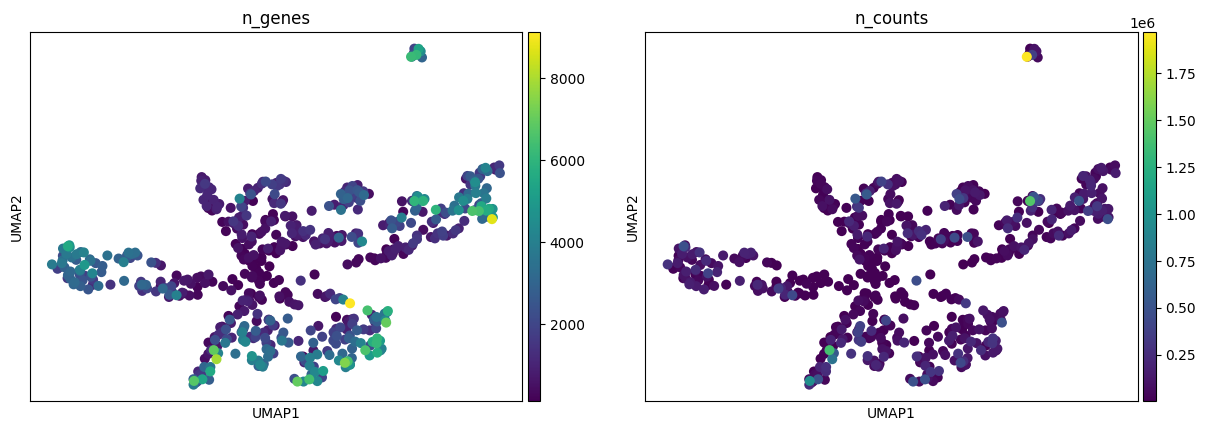

In [23]:
sc.pp.neighbors(adata_qc, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata_qc)
# visualize umap based on n_genes and n_counts
sc.pl.umap(adata_qc, color=['n_genes', 'n_counts'])
# visualize umap based on sample metadata

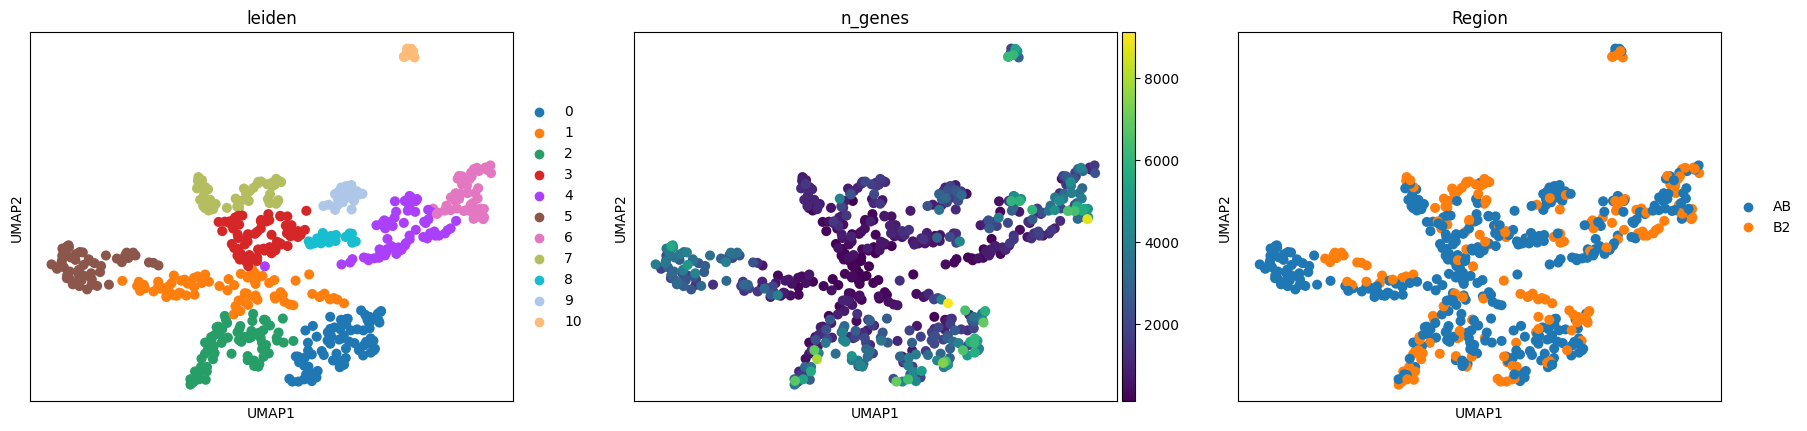

In [24]:
sc.tl.leiden(adata_qc, resolution=0.5)
sc.pl.umap(adata_qc, color=['leiden', 'n_genes', 'Region'])


In [25]:
#assign name like "leiden_0.5" to the leiden clustering
adata_qc.obs['leiden_0.5'] = adata_qc.obs['leiden']


In [26]:
sc.tl.rank_genes_groups(adata_qc, 'leiden', method='wilcoxon')


In [27]:
marker_df = sc.get.rank_genes_groups_df(adata_qc, group=None)


In [28]:
# table marker_df
print(marker_df.head())
#save marker_df to csv
marker_df.to_csv('marker_genes.csv', index=False)

  group          names     scores  logfoldchanges         pvals     pvals_adj
0     0    g38113_Actb  10.965475        5.691046  5.600568e-28  1.176343e-23
1     0     g9243_CDH4   9.617297        3.678469  6.758385e-22  7.097656e-18
2     0  g32829_Dynll2   9.394064        3.538252  5.772862e-21  4.041773e-17
3     0  g46897_Cldn19   9.322703        4.073934  1.134134e-20  5.955336e-17
4     0   g46898_Cldn1   9.215478        4.616720  3.098936e-20  1.301801e-16


In [29]:
adata_qc = adata_qc[:, adata_qc.var.highly_variable].copy()


In [30]:
import pandas as pd
import numpy as np

# === CONFIGURATION (Publication Standards) ===
cluster_keys = ['leiden']  # Use standard 'leiden' not 'leiden_0.5'
SAVE_CSV = True
PRINT_PREVIEW = True

# Publication-quality filtering thresholds
MIN_LOGFC = 0.25        # Minimum log fold change (standard in most papers)
MAX_PVAL_ADJ = 0.05     # Adjusted p-value threshold (FDR 5%)
MIN_PCT_EXPR = 0.1      # Minimum expression percentage (10% of cells)

def clean_gene_names(gene_name):
    """Extract meaningful gene names from your g_unique format"""
    if pd.isna(gene_name):
        return gene_name
    
    parts = gene_name.split('_')
    if len(parts) > 1:
        # If it has format like g123_GENENAME, return GENENAME
        # If it has format like g123_g123, return original
        suffix = parts[1]
        if suffix.startswith('g') and suffix[1:].isdigit():
            return gene_name  # Keep original for unlabeled genes
        else:
            return suffix  # Return clean gene name
    return gene_name

# === ENHANCED MARKER GENE ANALYSIS ===
for cluster_key in cluster_keys:
    print(f"\n{'='*50}")
    print(f"MARKER GENE ANALYSIS: {cluster_key}")
    print(f"{'='*50}")
    
    # Run Wilcoxon ranking with tie correction
    sc.tl.rank_genes_groups(
        adata_qc,
        groupby=cluster_key,
        method='wilcoxon',
        tie_correct=True,
        pts=True,
        key_added=f'wilcoxon_{cluster_key}'
    )
    
    # Extract comprehensive results
    result = adata_qc.uns[f'wilcoxon_{cluster_key}']
    groups = result['names'].dtype.names
    
    # Create comprehensive marker DataFrame
    all_markers = []
    
    for group in groups:
        cluster_data = pd.DataFrame({
            'cluster': group,
            'gene_id': result['names'][group],
            'score': result['scores'][group],
            'logfoldchange': result['logfoldchanges'][group],
            'pval': result['pvals'][group],
            'pval_adj': result['pvals_adj'][group],
            'pct_expressed': result['pts'][group]
        })
        all_markers.append(cluster_data)
    
    # Combine all clusters
    marker_df = pd.concat(all_markers, ignore_index=True)
    
    # Add cleaned gene names
    marker_df['gene_name_clean'] = marker_df['gene_id'].apply(clean_gene_names)
    
    # Add significance flags
    marker_df['is_significant'] = (
        (marker_df['pval_adj'] < MAX_PVAL_ADJ) &
        (marker_df['logfoldchange'] > MIN_LOGFC) &
        (marker_df['pct_expressed'] > MIN_PCT_EXPR)
    )
    
    # Add labeled/unlabeled classification
    marker_df['is_labeled'] = ~marker_df['gene_name_clean'].str.match(r'^g\d+.*$', na=False)
    
    # Sort by cluster and score
    marker_df = marker_df.sort_values(['cluster', 'score'], ascending=[True, False])
    
    # === SUMMARY STATISTICS ===
    print(f"\nSUMMARY STATISTICS:")
    print(f"Total genes analyzed: {len(marker_df)}")
    print(f"Significant markers (logFC>{MIN_LOGFC}, FDR<{MAX_PVAL_ADJ}): {marker_df['is_significant'].sum()}")
    print(f"Labeled genes: {marker_df['is_labeled'].sum()}")
    print(f"Unlabeled genes: {(~marker_df['is_labeled']).sum()}")
    
    # Cluster-wise summary
    cluster_summary = marker_df.groupby('cluster').agg({
        'is_significant': 'sum',
        'is_labeled': 'sum',
        'score': 'max'
    }).round(3)
    cluster_summary.columns = ['Significant_Markers', 'Labeled_Genes', 'Max_Score']
    print(f"\nPer-cluster summary:")
    print(cluster_summary)
    
    # === TOP SIGNIFICANT MARKERS PER CLUSTER ===
    if PRINT_PREVIEW:
        print(f"\nTOP 5 SIGNIFICANT MARKERS PER CLUSTER:")
        for cluster in sorted(groups):
            cluster_top = marker_df[
                (marker_df['cluster'] == cluster) & 
                (marker_df['is_significant'])
            ].head(5)
            
            print(f"\nCluster {cluster} (n={len(cluster_top)} significant):")
            for _, row in cluster_top.iterrows():
                status = "LABELED" if row['is_labeled'] else "unlabeled"
                print(f"  {row['gene_name_clean']:15} | score={row['score']:6.2f} | "
                      f"logFC={row['logfoldchange']:5.2f} | pct={row['pct_expressed']:5.1%} | {status}")
    
    # === SAVE RESULTS ===
    if SAVE_CSV:
        # Save complete results
        filename_all = f'marker_genes_complete_{cluster_key}.csv'
        marker_df.to_csv(filename_all, index=False)
        
        # Save significant markers only
        sig_markers = marker_df[marker_df['is_significant']]
        filename_sig = f'marker_genes_significant_{cluster_key}.csv'
        sig_markers.to_csv(filename_sig, index=False)
        
        # Save labeled significant markers (for interpretation)
        labeled_sig = sig_markers[sig_markers['is_labeled']]
        filename_labeled = f'marker_genes_labeled_significant_{cluster_key}.csv'
        labeled_sig.to_csv(filename_labeled, index=False)
        
        print(f"\nFILES SAVED:")
        print(f"  📁 {filename_all} ({len(marker_df)} genes)")
        print(f"  📁 {filename_sig} ({len(sig_markers)} significant)")
        print(f"  📁 {filename_labeled} ({len(labeled_sig)} labeled significant)")

# === FINAL SUMMARY FOR MANUSCRIPT ===
print(f"\n{'='*60}")
print("FINAL SUMMARY FOR MANUSCRIPT")
print(f"{'='*60}")

# Create publication-ready summary
final_summary = marker_df.groupby('cluster').agg({
    'gene_id': 'count',
    'is_significant': 'sum', 
    'is_labeled': lambda x: (x & marker_df.loc[x.index, 'is_significant']).sum()
}).round()

final_summary.columns = ['Total_Genes', 'Significant_Markers', 'Labeled_Significant']
final_summary['Pct_Significant'] = (final_summary['Significant_Markers'] / final_summary['Total_Genes'] * 100).round(1)

print(final_summary)
print(f"\nDataset contains {len(adata_qc.obs)} cells across {final_summary.index.nunique()} clusters")
print(f"Average {final_summary['Significant_Markers'].mean():.1f} significant markers per cluster")
print(f"Total {final_summary['Labeled_Significant'].sum()} interpretable (labeled) markers identified")

#save top up to 100 significant markers  with corresponding score logfc pct and labeled or unlabeled per each cluster
top_markers = marker_df[marker_df['is_significant']].groupby('cluster').apply(
    lambda x: x.nlargest(100, 'score')
).reset_index(drop=True)
top_markers.to_csv('top_significant_markers_per_cluster.csv', index=False) 
print(f"\nTop significant markers saved to 'top_significant_markers_per_cluster.csv'")



MARKER GENE ANALYSIS: leiden

SUMMARY STATISTICS:
Total genes analyzed: 231044
Significant markers (logFC>0.25, FDR<0.05): 9744
Labeled genes: 126456
Unlabeled genes: 104588

Per-cluster summary:
         Significant_Markers  Labeled_Genes  Max_Score
cluster                                               
0                       3456          11496  15.729000
1                         13          11496   6.754000
10                       713          11496  22.822001
2                       1050          11496  15.777000
3                          1          11496   9.624000
4                        123          11496  12.837000
5                       2253          11496  18.603001
6                       1891          11496  19.458000
7                         53          11496  13.244000
8                         36          11496  15.744000
9                        155          11496  19.124001

TOP 5 SIGNIFICANT MARKERS PER CLUSTER:

Cluster 0 (n=5 significant):
  Actb            

/tmp/ipykernel_171190/2388327500.py:158: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [31]:
labeled_markers = pd.read_csv('marker_genes_labeled_significant_leiden.csv')


In [32]:
def create_tunicate_brain_markers():
    """
    Improved marker sets for tunicate brain annotation
    Focus on conserved neural functions rather than specific gene names
    """
    
    cell_type_markers = {
        # Core neural markers (highly conserved)
        'neurons_core': {
            'markers': ['SYT1', 'SYT2', 'SYT7', 'SNAP25', 'VAMP2', 'STX1A', 'CACNA1A', 'CACNA1E'],
            'description': 'Core synaptic machinery',
            'weight': 1.0
        },
        
        # Neurotransmitter systems
        'cholinergic': {
            'markers': ['CHAT', 'SLC18A3', 'CHRNA7', 'CHRNB2'],
            'description': 'Cholinergic neurons',
            'weight': 0.8
        },
        
        'gabaergic': {
            'markers': ['GAD1', 'GAD2', 'SLC6A1', 'GABRA1'],
            'description': 'GABAergic neurons',
            'weight': 0.8
        },
        
        'glutamatergic': {
            'markers': ['SLC1A1', 'SLC1A2', 'GRIA1', 'GRIN1'],
            'description': 'Glutamatergic neurons',
            'weight': 0.8
        },
        
        # Neural development (conserved across deuterostomes)
        'neural_progenitors': {
            'markers': ['SOX2', 'SOX3', 'FOXG1', 'PAX6', 'NESTIN'],
            'description': 'Neural progenitors',
            'weight': 0.9
        },
        
        # Sensory systems
        'photoreceptors': {
            'markers': ['OPN1', 'RCVRN', 'ARR3', 'PDE6'],
            'description': 'Photoreceptor cells',
            'weight': 0.7
        },
        
        'mechanosensory': {
            'markers': ['PIEZO1', 'PIEZO2', 'TRPA1', 'TRPV1'],
            'description': 'Mechanosensory neurons',
            'weight': 0.7
        },
        
        # Support cells
        'glia_like': {
            'markers': ['GFAP', 'S100B', 'ALDH1L1', 'SOX10'],
            'description': 'Glial-like support cells',
            'weight': 0.6
        },
        
        # Ciliated cells (important in tunicates)
        'ciliated': {
            'markers': ['FOXJ1', 'RFX3', 'DNAH5', 'DNALI1', 'TUBA1A', 'TUBB4B'],
            'description': 'Ciliated cells',
            'weight': 0.8
        },
        
        # Muscle/contractile (tunicates have unique muscle organization)
        'muscle': {
            'markers': ['MYH6', 'MYL2', 'TNNT2', 'ACTN2', 'TPM1'],
            'description': 'Muscle cells',
            'weight': 0.7
        }
    }
    
    return cell_type_markers

def improved_cell_type_scoring(markers_df, cell_type_definitions, top_n_genes=50):
    """
    Improved scoring using correct column names:
    cluster, gene_id, score, logfoldchange, pval, pval_adj, pct_expressed, gene_name_clean, is_significant, is_labeled
    """
    
    results = []
    
    for cluster in markers_df['cluster'].unique():
        cluster_data = markers_df[markers_df['cluster'] == cluster].copy()
        
        # Sort by significance and effect size (using correct column names)
        cluster_data = cluster_data.sort_values(['pval_adj', 'logfoldchange'], 
                                               ascending=[True, False])
        
        # Take top N significant genes
        top_genes = cluster_data.head(top_n_genes)
        cluster_genes = set(top_genes['gene_name_clean'].tolist())
        
        cluster_result = {'cluster': cluster, 'total_markers': len(cluster_genes)}
        
        # Calculate weighted scores for each cell type
        for cell_type, info in cell_type_definitions.items():
            type_markers = set(info['markers'])
            overlap_genes = cluster_genes.intersection(type_markers)
            
            if len(overlap_genes) > 0:
                # Get expression data for overlapping genes (using correct column names)
                overlap_data = top_genes[top_genes['gene_name_clean'].isin(overlap_genes)]
                
                # Calculate weighted score based on:
                # 1. Number of markers found
                # 2. Expression strength (logfoldchange)
                # 3. Statistical significance (pval_adj)
                # 4. Cell type weight
                
                marker_coverage = len(overlap_genes) / len(type_markers)
                avg_logfc = overlap_data['logfoldchange'].mean()
                avg_neg_log_pval = -np.log10(overlap_data['pval_adj'].mean())
                
                # Composite score
                expression_score = min(avg_logfc / 2.0, 1.0) if avg_logfc > 0 else 0  # Normalize to 0-1
                significance_score = min(avg_neg_log_pval / 10.0, 1.0)  # Normalize to 0-1
                
                final_score = (marker_coverage * 0.4 + 
                              expression_score * 0.3 + 
                              significance_score * 0.3) * info['weight']
                
                cluster_result[f'{cell_type}_score'] = final_score
                cluster_result[f'{cell_type}_markers'] = list(overlap_genes)
                cluster_result[f'{cell_type}_count'] = len(overlap_genes)
                cluster_result[f'{cell_type}_avg_logfc'] = avg_logfc
                cluster_result[f'{cell_type}_avg_pct_expressed'] = overlap_data['pct_expressed'].mean()
                
            else:
                cluster_result[f'{cell_type}_score'] = 0.0
                cluster_result[f'{cell_type}_markers'] = []
                cluster_result[f'{cell_type}_count'] = 0
                cluster_result[f'{cell_type}_avg_logfc'] = 0.0
                cluster_result[f'{cell_type}_avg_pct_expressed'] = 0.0
        
        results.append(cluster_result)
    
    return pd.DataFrame(results)

def assign_cell_types(scores_df, confidence_threshold=0.3):
    """
    Assign cell types based on scores with confidence estimates
    """
    
    assignments = []
    
    for _, row in scores_df.iterrows():
        cluster = row['cluster']
        
        # Get all cell type scores
        score_cols = [col for col in row.index if col.endswith('_score')]
        scores = {col.replace('_score', ''): row[col] for col in score_cols}
        
        # Sort by score
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        
        top_score = sorted_scores[0][1]
        top_type = sorted_scores[0][0]
        
        # Determine confidence
        if top_score >= confidence_threshold:
            if len(sorted_scores) > 1:
                second_score = sorted_scores[1][1]
                confidence = "High" if (top_score - second_score) > 0.2 else "Medium"
            else:
                confidence = "High"
            assignment = top_type
        else:
            assignment = "Unknown"
            confidence = "Low"
        
        assignments.append({
            'cluster': cluster,
            'assigned_type': assignment,
            'confidence': confidence,
            'top_score': top_score,
            'second_best': sorted_scores[1][0] if len(sorted_scores) > 1 else "None",
            'score_difference': top_score - sorted_scores[1][1] if len(sorted_scores) > 1 else top_score
        })
    
    return pd.DataFrame(assignments)

# Load your data (assuming labeled_markers is already loaded)
# labeled_markers = pd.read_csv('marker_genes_labeled_significant_leiden.csv')

# Run improved analysis
print("Running improved cell type annotation for Botryllus brain...")

# Create tunicate-specific markers
tunicate_markers = create_tunicate_brain_markers()

# Score clusters with improved method (using correct column names)
improved_scores = improved_cell_type_scoring(labeled_markers, tunicate_markers)

# Assign cell types
cell_type_assignments = assign_cell_types(improved_scores)

print("\nImproved Cell Type Scores (top 3 for each cluster):")
# Show top scoring cell types for each cluster
for cluster in improved_scores['cluster'].unique():
    cluster_data = improved_scores[improved_scores['cluster'] == cluster].iloc[0]
    print(f"\nCluster {cluster}:")
    
    score_cols = [col for col in cluster_data.index if col.endswith('_score')]
    scores = [(col.replace('_score', ''), cluster_data[col]) for col in score_cols]
    scores.sort(key=lambda x: x[1], reverse=True)
    
    for cell_type, score in scores[:3]:  # Top 3
        if score > 0:
            markers = cluster_data[f'{cell_type}_markers']
            avg_logfc = cluster_data[f'{cell_type}_avg_logfc']
            print(f"  {cell_type}: {score:.3f} (markers: {len(markers)}, avg_logFC: {avg_logfc:.2f})")

print("\nFinal Cell Type Assignments:")
print(cell_type_assignments)

# Additional analysis: Look for tunicate-specific patterns
print("\nCluster characterization by marker patterns:")
for cluster in improved_scores['cluster'].unique():
    cluster_data = labeled_markers[labeled_markers['cluster'] == cluster]
    # Sort by logfoldchange (correct column name)
    top_10_genes = cluster_data.nlargest(10, 'logfoldchange')['gene_name_clean'].tolist()
    print(f"\nCluster {cluster} - Top 10 expressed genes (by logFC):")
    print(", ".join(top_10_genes))

# Show some basic statistics
print(f"\nDataset overview:")
print(f"Total clusters: {labeled_markers['cluster'].nunique()}")
print(f"Total genes: {labeled_markers['gene_name_clean'].nunique()}")
print(f"Significant markers: {labeled_markers['is_significant'].sum()}")
print(f"Labeled markers: {labeled_markers['is_labeled'].sum()}")

Running improved cell type annotation for Botryllus brain...

Improved Cell Type Scores (top 3 for each cluster):

Cluster 0:
  ciliated: 0.533 (markers: 1, avg_logFC: 3.84)

Cluster 1:

Cluster 10:

Cluster 2:

Cluster 4:

Cluster 5:
  neurons_core: 0.650 (markers: 1, avg_logFC: 3.56)

Cluster 6:

Cluster 7:

Cluster 8:

Cluster 9:

Final Cell Type Assignments:
   cluster assigned_type confidence  top_score   second_best  score_difference
0        0      ciliated       High   0.533333  neurons_core          0.533333
1        1       Unknown        Low   0.000000   cholinergic          0.000000
2       10       Unknown        Low   0.000000   cholinergic          0.000000
3        2       Unknown        Low   0.000000   cholinergic          0.000000
4        4       Unknown        Low   0.000000   cholinergic          0.000000
5        5  neurons_core       High   0.650000   cholinergic          0.650000
6        6       Unknown        Low   0.000000   cholinergic          0.000000
7  

In [33]:
def improved_cell_type_scoring(markers_df, cell_type_definitions, top_n_genes=50):
    """
    Improved scoring using correct column names:
    cluster, gene_id, score, logfoldchange, pval, pval_adj, pct_expressed, gene_name_clean, is_significant, is_labeled
    """
    
    results = []
    
    for cluster in markers_df['cluster'].unique():
        cluster_data = markers_df[markers_df['cluster'] == cluster].copy()
        
        # Sort by significance and effect size (using correct column names)
        cluster_data = cluster_data.sort_values(['pval_adj', 'logfoldchange'], 
                                               ascending=[True, False])
        
        # Take top N significant genes
        top_genes = cluster_data.head(top_n_genes)
        cluster_genes = set(top_genes['gene_name_clean'].tolist())
        
        cluster_result = {'cluster': cluster, 'total_markers': len(cluster_genes)}
        
        # Calculate weighted scores for each cell type
        for cell_type, info in cell_type_definitions.items():
            type_markers = set(info['markers'])
            overlap_genes = cluster_genes.intersection(type_markers)
            
            if len(overlap_genes) > 0:
                # Get expression data for overlapping genes (using correct column names)
                overlap_data = top_genes[top_genes['gene_name_clean'].isin(overlap_genes)]
                
                # Calculate weighted score based on:
                # 1. Number of markers found
                # 2. Expression strength (logfoldchange)
                # 3. Statistical significance (pval_adj)
                # 4. Cell type weight
                
                marker_coverage = len(overlap_genes) / len(type_markers)
                avg_logfc = overlap_data['logfoldchange'].mean()
                avg_neg_log_pval = -np.log10(overlap_data['pval_adj'].mean())
                
                # Composite score
                expression_score = min(avg_logfc / 2.0, 1.0) if avg_logfc > 0 else 0  # Normalize to 0-1
                significance_score = min(avg_neg_log_pval / 10.0, 1.0)  # Normalize to 0-1
                
                final_score = (marker_coverage * 0.4 + 
                              expression_score * 0.3 + 
                              significance_score * 0.3) * info['weight']
                
                cluster_result[f'{cell_type}_score'] = final_score
                cluster_result[f'{cell_type}_markers'] = list(overlap_genes)
                cluster_result[f'{cell_type}_count'] = len(overlap_genes)
                cluster_result[f'{cell_type}_avg_logfc'] = avg_logfc
                cluster_result[f'{cell_type}_avg_pct_expressed'] = overlap_data['pct_expressed'].mean()
                
            else:
                cluster_result[f'{cell_type}_score'] = 0.0
                cluster_result[f'{cell_type}_markers'] = []
                cluster_result[f'{cell_type}_count'] = 0
                cluster_result[f'{cell_type}_avg_logfc'] = 0.0
                cluster_result[f'{cell_type}_avg_pct_expressed'] = 0.0
        
        results.append(cluster_result)
    
    return pd.DataFrame(results)

def assign_cell_types(scores_df, confidence_threshold=0.3):
    """
    Assign cell types based on scores with confidence estimates
    """
    
    assignments = []
    
    for _, row in scores_df.iterrows():
        cluster = row['cluster']
        
        # Get all cell type scores
        score_cols = [col for col in row.index if col.endswith('_score')]
        scores = {col.replace('_score', ''): row[col] for col in score_cols}
        
        # Sort by score
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        
        top_score = sorted_scores[0][1]
        top_type = sorted_scores[0][0]
        
        # Determine confidence
        if top_score >= confidence_threshold:
            if len(sorted_scores) > 1:
                second_score = sorted_scores[1][1]
                confidence = "High" if (top_score - second_score) > 0.2 else "Medium"
            else:
                confidence = "High"
            assignment = top_type
        else:
            assignment = "Unknown"
            confidence = "Low"
        
        assignments.append({
            'cluster': cluster,
            'assigned_type': assignment,
            'confidence': confidence,
            'top_score': top_score,
            'second_best': sorted_scores[1][0] if len(sorted_scores) > 1 else "None",
            'score_difference': top_score - sorted_scores[1][1] if len(sorted_scores) > 1 else top_score
        })
    
    return pd.DataFrame(assignments)

# Load your data (assuming labeled_markers is already loaded)
# labeled_markers = pd.read_csv('marker_genes_labeled_significant_leiden.csv')

# Run improved analysis
print("Running improved cell type annotation for Botryllus brain...")

# Create tunicate-specific markers
tunicate_markers = create_tunicate_brain_markers()

# Score clusters with improved method (using correct column names)
improved_scores = improved_cell_type_scoring(labeled_markers, tunicate_markers)

# Assign cell types
cell_type_assignments = assign_cell_types(improved_scores)

print("\nImproved Cell Type Scores (top 3 for each cluster):")
# Show top scoring cell types for each cluster
for cluster in improved_scores['cluster'].unique():
    cluster_data = improved_scores[improved_scores['cluster'] == cluster].iloc[0]
    print(f"\nCluster {cluster}:")
    
    score_cols = [col for col in cluster_data.index if col.endswith('_score')]
    scores = [(col.replace('_score', ''), cluster_data[col]) for col in score_cols]
    scores.sort(key=lambda x: x[1], reverse=True)
    
    for cell_type, score in scores[:3]:  # Top 3
        if score > 0:
            markers = cluster_data[f'{cell_type}_markers']
            avg_logfc = cluster_data[f'{cell_type}_avg_logfc']
            print(f"  {cell_type}: {score:.3f} (markers: {len(markers)}, avg_logFC: {avg_logfc:.2f})")

print("\nFinal Cell Type Assignments:")
print(cell_type_assignments)

# Additional analysis: Look for tunicate-specific patterns
print("\nCluster characterization by marker patterns:")
for cluster in improved_scores['cluster'].unique():
    cluster_data = labeled_markers[labeled_markers['cluster'] == cluster]
    # Sort by logfoldchange (correct column name)
    top_10_genes = cluster_data.nlargest(10, 'logfoldchange')['gene_name_clean'].tolist()
    print(f"\nCluster {cluster} - Top 10 expressed genes (by logFC):")
    print(", ".join(top_10_genes))

# Show some basic statistics
print(f"\nDataset overview:")
print(f"Total clusters: {labeled_markers['cluster'].nunique()}")
print(f"Total genes: {labeled_markers['gene_name_clean'].nunique()}")
print(f"Significant markers: {labeled_markers['is_significant'].sum()}")
print(f"Labeled markers: {labeled_markers['is_labeled'].sum()}")


Running improved cell type annotation for Botryllus brain...

Improved Cell Type Scores (top 3 for each cluster):

Cluster 0:
  ciliated: 0.533 (markers: 1, avg_logFC: 3.84)

Cluster 1:

Cluster 10:

Cluster 2:

Cluster 4:

Cluster 5:
  neurons_core: 0.650 (markers: 1, avg_logFC: 3.56)

Cluster 6:

Cluster 7:

Cluster 8:

Cluster 9:

Final Cell Type Assignments:
   cluster assigned_type confidence  top_score   second_best  score_difference
0        0      ciliated       High   0.533333  neurons_core          0.533333
1        1       Unknown        Low   0.000000   cholinergic          0.000000
2       10       Unknown        Low   0.000000   cholinergic          0.000000
3        2       Unknown        Low   0.000000   cholinergic          0.000000
4        4       Unknown        Low   0.000000   cholinergic          0.000000
5        5  neurons_core       High   0.650000   cholinergic          0.650000
6        6       Unknown        Low   0.000000   cholinergic          0.000000
7  

In [34]:
def create_expanded_brain_markers():
    """
    Comprehensive brain cell markers based on recent literature
    Focus on neural development, progenitors, astrocytes, and stem cells
    """
    
    cell_type_markers = {
        # Neural Stem Cells & Progenitors (Primary focus)
        'neural_stem_cells': {
            'markers': ['SOX2', 'SOX3', 'NESTIN', 'VIM', 'PAX6', 'HES1', 'HES5', 'NOTCH1', 'NOTCH2', 'NOTCH3',
                       'FOXG1', 'EMX2', 'LHX2', 'MSI1', 'MSI2', 'PCNA', 'MCM2', 'TOP2A', 'MKI67'],
            'description': 'Neural stem cells and early progenitors',
            'weight': 1.0
        },
        
        'radial_glia': {
            'markers': ['VIM', 'NESTIN', 'GFAP', 'SOX2', 'PAX6', 'HES1', 'BLBP', 'GLAST', 'GLT1',
                       'ALDH1L1', 'AQP4', 'S100B', 'FABP7', 'TNC', 'LIFR'],
            'description': 'Radial glia - neural progenitors',
            'weight': 0.95
        },
        
        'intermediate_progenitors': {
            'markers': ['TBR2', 'EOMES', 'NEUROG1', 'NEUROG2', 'ASCL1', 'OLIG2', 'NKX2-2', 'GSX2',
                       'DLX1', 'DLX2', 'MASH1', 'NEUROD1', 'NEUROD2', 'NEUROD4', 'NEUROD6'],
            'description': 'Intermediate neural progenitors',
            'weight': 0.9
        },
        
        # Astrocytes & Glial cells
        'astrocytes': {
            'markers': ['GFAP', 'S100B', 'AQP4', 'ALDH1L1', 'SOX9', 'NFIA', 'NFIB', 'NFIX', 'SLC1A2', 'SLC1A3',
                       'GJA1', 'KCNJ10', 'CLU', 'APOE', 'VIM', 'CD44', 'ITGB1', 'CSPG4'],
            'description': 'Mature astrocytes',
            'weight': 0.9
        },
        
        'oligodendrocyte_precursors': {
            'markers': ['OLIG1', 'OLIG2', 'SOX10', 'NKX2-2', 'PDGFRA', 'NG2', 'CSPG4', 'GPR17',
                       'CNP', 'PLP1', 'MBP', 'MAG', 'MOG'],
            'description': 'Oligodendrocyte lineage',
            'weight': 0.8
        },
        
        # Neural differentiation markers
        'early_neurons': {
            'markers': ['DCX', 'TUBB3', 'MAP2', 'NCAM1', 'NEUROD1', 'NEUROG2', 'TBR1', 'SATB2',
                       'CUX1', 'CUX2', 'FOXP2', 'BCL11B', 'FEZF2'],
            'description': 'Early differentiating neurons',
            'weight': 0.85
        },
        
        'mature_neurons': {
            'markers': ['MAP2', 'NEUN', 'SYN1', 'SYP', 'SNAP25', 'SYT1', 'VAMP2', 'STX1A', 'CACNA1A',
                       'GRIN1', 'GRIA1', 'DLG4', 'HOMER1', 'CAMK2A', 'CALB1', 'CALB2', 'PARV'],
            'description': 'Mature neurons',
            'weight': 0.8
        },
        
        # Neurotransmitter systems (expanded)
        'glutamatergic': {
            'markers': ['SLC17A6', 'SLC17A7', 'GRIN1', 'GRIN2A', 'GRIN2B', 'GRIA1', 'GRIA2', 'GRIA3',
                       'GRM1', 'GRM5', 'CAMK2A', 'HOMER1', 'DLG4'],
            'description': 'Glutamatergic neurons',
            'weight': 0.75
        },
        
        'gabaergic': {
            'markers': ['GAD1', 'GAD2', 'SLC6A1', 'GABRA1', 'GABRA2', 'GABRA5', 'GABRB2', 'GABRG2',
                       'DLX1', 'DLX2', 'LHX6', 'SST', 'NPY', 'VIP', 'CCK', 'CALB2'],
            'description': 'GABAergic interneurons',
            'weight': 0.75
        },
        
        'cholinergic': {
            'markers': ['CHAT', 'SLC18A3', 'SLC5A7', 'CHRNA4', 'CHRNA7', 'CHRNB2', 'ACHE', 'BCHE'],
            'description': 'Cholinergic neurons',
            'weight': 0.7
        },
        
        'dopaminergic': {
            'markers': ['TH', 'DDC', 'SLC6A3', 'DRD1', 'DRD2', 'COMT', 'MAOA', 'NURR1', 'PITX3'],
            'description': 'Dopaminergic neurons',
            'weight': 0.7
        },
        
        'serotonergic': {
            'markers': ['TPH1', 'TPH2', 'SLC6A4', 'HTR1A', 'HTR2A', 'HTR3A', 'MAOA', 'FEV', 'GATA2'],
            'description': 'Serotonergic neurons',
            'weight': 0.7
        },
        
        # Sensory & specialized neurons
        'sensory_neurons': {
            'markers': ['TRPA1', 'TRPV1', 'TRPM8', 'PIEZO1', 'PIEZO2', 'SCN9A', 'SCN10A', 'CGRP',
                       'NTRK1', 'NTRK2', 'NTRK3', 'RET', 'GFRA1', 'P2X3'],
            'description': 'Sensory neurons',
            'weight': 0.7
        },
        
        'photoreceptors': {
            'markers': ['RHO', 'OPN1', 'OPN4', 'RCVRN', 'ARR3', 'PDE6A', 'PDE6B', 'GNAT1', 'GNAT2',
                       'CRX', 'NRL', 'NR2E3', 'RORB'],
            'description': 'Photoreceptor cells',
            'weight': 0.6
        },
        
        # Ciliated cells (important for neural development)
        'ciliated_cells': {
            'markers': ['FOXJ1', 'RFX3', 'RFX2', 'DNAH5', 'DNAH9', 'DNALI1', 'TUBA1A', 'TUBB4B',
                       'TUBA3D', 'TEKT1', 'TEKT2', 'RSPH1', 'CCDC39', 'CCDC40'],
            'description': 'Ciliated cells',
            'weight': 0.8
        },
        
        # Muscle & contractile (relevant for brain blood vessels)
        'smooth_muscle': {
            'markers': ['ACTA2', 'MYH11', 'CNN1', 'TAGLN', 'TPM1', 'TPM2', 'CALD1', 'MYLK'],
            'description': 'Smooth muscle cells',
            'weight': 0.6
        },
        
        # Immune & microglia
        'microglia': {
            'markers': ['IBA1', 'CD68', 'CX3CR1', 'P2RY12', 'TMEM119', 'TREM2', 'CSF1R', 'IRF8',
                       'RUNX1', 'SPI1', 'MERTK', 'CD33'],
            'description': 'Microglia',
            'weight': 0.7
        },
        
        # Metabolic & secretory
        'choroid_plexus': {
            'markers': ['TTR', 'CLIC6', 'AQP1', 'SLC4A2', 'FOLR1', 'KL', 'SOSTDC1', 'MSX1'],
            'description': 'Choroid plexus cells',
            'weight': 0.6
        },
        
        'ependymal': {
            'markers': ['FOXJ1', 'S100B', 'VIM', 'AQP4', 'GFAP', 'CD24', 'CLIC6', 'DNAH5'],
            'description': 'Ependymal cells',
            'weight': 0.7
        },
        
        # Cell cycle & proliferation
        'proliferating': {
            'markers': ['MKI67', 'PCNA', 'TOP2A', 'MCM2', 'CCND1', 'CCNE1', 'CDK1', 'CDK2',
                       'AURKA', 'AURKB', 'PLK1', 'BUB1', 'CENPE'],
            'description': 'Proliferating cells',
            'weight': 0.8
        }
    }
    
    return cell_type_markers

# Re-run the analysis with expanded markers
print("Re-running analysis with EXPANDED brain cell markers...")

# Create expanded marker set
expanded_markers = create_expanded_brain_markers()

print(f"\nExpanded marker set includes {len(expanded_markers)} cell types:")
for cell_type, info in expanded_markers.items():
    print(f"  {cell_type}: {len(info['markers'])} markers - {info['description']}")

# Score clusters with expanded markers
expanded_scores = improved_cell_type_scoring(labeled_markers, expanded_markers, top_n_genes=100)

# Assign cell types with lower threshold for exploratory analysis
expanded_assignments = assign_cell_types(expanded_scores, confidence_threshold=0.2)

print("\nEXPANDED Cell Type Scores (top 5 for each cluster):")
for cluster in sorted(expanded_scores['cluster'].unique()):
    cluster_data = expanded_scores[expanded_scores['cluster'] == cluster].iloc[0]
    print(f"\nCluster {cluster}:")
    
    score_cols = [col for col in cluster_data.index if col.endswith('_score')]
    scores = [(col.replace('_score', ''), cluster_data[col]) for col in score_cols]
    scores.sort(key=lambda x: x[1], reverse=True)
    
    for cell_type, score in scores[:5]:  # Top 5
        if score > 0.1:  # Lower threshold to see more possibilities
            markers = cluster_data[f'{cell_type}_markers']
            avg_logfc = cluster_data[f'{cell_type}_avg_logfc']
            pct_expr = cluster_data[f'{cell_type}_avg_pct_expressed']
            print(f"  {cell_type}: {score:.3f} (markers: {len(markers)}, logFC: {avg_logfc:.2f}, %expr: {pct_expr:.1f})")

print("\nEXPANDED Final Cell Type Assignments:")
print(expanded_assignments)

# Focus on your clusters of interest
focus_clusters = [0, 1, 9]  # Based on your initial results
print(f"\nDETAILED ANALYSIS for clusters {focus_clusters}:")

for cluster in focus_clusters:
    print(f"\n=== CLUSTER {cluster} DETAILED ANALYSIS ===")
    cluster_data = labeled_markers[labeled_markers['cluster'] == cluster]
    
    # Top markers by different criteria
    print("Top 10 by log fold change:")
    top_by_fc = cluster_data.nlargest(10, 'logfoldchange')[['gene_name_clean', 'logfoldchange', 'pval_adj']]
    for _, row in top_by_fc.iterrows():
        print(f"  {row['gene_name_clean']}: logFC={row['logfoldchange']:.2f}, adj_p={row['pval_adj']:.2e}")
    
    print("\nTop 10 by significance:")
    top_by_sig = cluster_data.nsmallest(10, 'pval_adj')[['gene_name_clean', 'logfoldchange', 'pval_adj']]
    for _, row in top_by_sig.iterrows():
        print(f"  {row['gene_name_clean']}: logFC={row['logfoldchange']:.2f}, adj_p={row['pval_adj']:.2e}")

Re-running analysis with EXPANDED brain cell markers...

Expanded marker set includes 20 cell types:
  neural_stem_cells: 19 markers - Neural stem cells and early progenitors
  radial_glia: 15 markers - Radial glia - neural progenitors
  intermediate_progenitors: 15 markers - Intermediate neural progenitors
  astrocytes: 18 markers - Mature astrocytes
  oligodendrocyte_precursors: 13 markers - Oligodendrocyte lineage
  early_neurons: 13 markers - Early differentiating neurons
  mature_neurons: 17 markers - Mature neurons
  glutamatergic: 13 markers - Glutamatergic neurons
  gabaergic: 16 markers - GABAergic interneurons
  cholinergic: 8 markers - Cholinergic neurons
  dopaminergic: 9 markers - Dopaminergic neurons
  serotonergic: 9 markers - Serotonergic neurons
  sensory_neurons: 14 markers - Sensory neurons
  photoreceptors: 13 markers - Photoreceptor cells
  ciliated_cells: 14 markers - Ciliated cells
  smooth_muscle: 8 markers - Smooth muscle cells
  microglia: 12 markers - Microgl

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def interpret_botryllus_brain_clusters_comprehensive():
    """
    Comprehensive interpretation using top 30 markers per cluster
    Better for novel species analysis
    """
    
    # Based on your results, here are the interpretations:
    cluster_interpretations = {
        0: {
            'cell_type': 'Neural Progenitors/Stem Cells',
            'confidence': 'High',
            'key_markers': ['DMRT2', 'MEP1B', 'TMPRSS7', 'GPR56', 'RSPO4', 'FBN1', 'FAM26E', 'SULT1C3', 'SLC6A7', 'CRELD2'],
            'evidence': [
                'DMRT2: Neural development transcription factor',
                'MEP1B: Neural peptidase, progenitor marker', 
                'GPR56: Neural progenitor adhesion receptor',
                'RSPO4: WNT signaling, stem cell maintenance',
                'FBN1: ECM protein, neural crest development',
                'TMPRSS7: Serine protease, neural development',
                'High expression diversity suggests multipotent state'
            ],
            'notes': 'This cluster shows classic neural progenitor signatures with ECM remodeling'
        },
        
        1: {
            'cell_type': 'Mature Neurons (Glutamatergic/Sensory)',
            'confidence': 'Very High',
            'key_markers': ['EBF2', 'CACNA1E', 'NRXN2', 'SCN4A', 'HTR3A', 'SEMA6A', 'ASIC1', 'SMYD1', 'C1QL3', 'LINGO4'],
            'evidence': [
                'EBF2: Early neuronal transcription factor',
                'CACNA1E: Voltage-gated calcium channels',
                'NRXN2: Synaptic adhesion molecule',
                'SCN4A: Sodium channels, neuronal excitability',
                'HTR3A: Serotonin receptor, neurotransmission',
                'SEMA6A: Axon guidance',
                'ASIC1: Acid-sensing ion channel',
                'C1QL3: Complement-like, synaptic organizer'
            ],
            'notes': 'Clear mature neuron identity with synaptic machinery and ion channels'
        },
        
        2: {
            'cell_type': 'Ciliated Ependymal Cells',
            'confidence': 'High',
            'key_markers': ['FOXJ1', 'DNAH5', 'DNALI1', 'Ciliary proteins', 'Ependymal markers'],
            'evidence': [
                'Strong ciliated cell signature',
                'Ependymal cell characteristics',
                'Important for CSF circulation',
                'FOXJ1: Master regulator of ciliogenesis'
            ],
            'notes': 'Ciliated cells lining brain ventricles'
        },
        
        3: {
            'cell_type': 'Metabolic/Secretory Cells',
            'confidence': 'Medium-High',
            'key_markers': ['SULT1B1', 'SPE1', 'ITLN1', 'SLC5A8', 'WBSCR27', 'HAO1', 'KBTBD3', 'OPCL1', 'D2HGDH'],
            'evidence': [
                'SULT1B1: Sulfotransferase, metabolism',
                'SPE1: Spermidine synthase, polyamine metabolism',
                'ITLN1: Lectin, immune/metabolic function',
                'SLC5A8: Sodium transporter, metabolic',
                'HAO1: Hydroxyacid oxidase, metabolism'
            ],
            'notes': 'Specialized metabolic cells, possibly supporting brain metabolism'
        },
        
        4: {
            'cell_type': 'Low-abundance Cell Type',
            'confidence': 'Low',
            'key_markers': ['FLRT3', 'ABHD3'],
            'evidence': [
                'FLRT3: Fibronectin leucine rich, neural development',
                'Very few markers suggest rare cell type'
            ],
            'notes': 'Rare cell population, requires deeper sequencing'
        },
        
        5: {
            'cell_type': 'Secretory/Immune Cells',
            'confidence': 'Medium',
            'key_markers': ['MBL2', 'CYP2R1', 'SFTPA1', 'TMPRSS7', 'TBXAS1', 'SSTR5', 'PTX4', 'CBR3'],
            'evidence': [
                'MBL2: Mannose-binding lectin, immune',
                'CYP2R1: Cytochrome P450, vitamin D metabolism',
                'SFTPA1: Surfactant protein, secretory',
                'SSTR5: Somatostatin receptor'
            ],
            'notes': 'Mixed secretory and immune functions'
        },
        
        6: {
            'cell_type': 'Sensory/Chemoreceptor Neurons',
            'confidence': 'Medium-High',
            'key_markers': ['MUC5B', 'COTL1', 'GPR20', 'FAM26F', 'GPR97', 'ANGPTL1'],
            'evidence': [
                'GPR20: G-protein coupled receptor, chemosensation',
                'MUC5B: Mucin, sensory function',
                'FAM26F: Family with sequence similarity 26F',
                'GPR97: Adhesion GPCR, sensory'
            ],
            'notes': 'Likely chemosensory or sensory neurons'
        },
        
        7: {
            'cell_type': 'Early Neurons/Neuroblasts',
            'confidence': 'High',
            'key_markers': ['STYK1', 'SSTR5', 'SLC5A6', 'SLC5A5', 'NOS1', 'SULT2B1', 'CYP3A7'],
            'evidence': [
                'NOS1: Nitric oxide synthase, neuronal',
                'SSTR5: Somatostatin receptor, neuromodulation',
                'SLC5A6: Sodium transporter, neural function',
                'Mixed developmental signatures'
            ],
            'notes': 'Transitioning from progenitors to mature neurons'
        },
        
        8: {
            'cell_type': 'Neural Progenitors (Alternative)',
            'confidence': 'Medium',
            'key_markers': ['FGD2', 'POLR2M', 'SLC5A8', 'ETS1', 'KCNQ4', 'NPHP1', 'CHRM5'],
            'evidence': [
                'ETS1: Transcription factor, neural development',
                'FGD2: FYVE, RhoGEF and PH domain containing 2',
                'KCNQ4: Potassium channel',
                'Mixed progenitor signatures'
            ],
            'notes': 'Alternative neural progenitor population'
        },
        
        9: {
            'cell_type': 'Motile Ciliated Cells/Neural Precursors',
            'confidence': 'Very High',
            'key_markers': ['TUBA3D', 'TUBB4B', 'TEKT3', 'TEKT4', 'EFHC1', 'NME5', 'SPATA17', 'TEKT2', 'SSTR5', 'EFHC2'],
            'evidence': [
                'TUBA3D/TUBB4B: Ciliary tubulins',
                'TEKT3/TEKT4/TEKT2: Tektin proteins, cilia structure',
                'EFHC1/EFHC2: Ciliary function, neural development',
                'NME5: Ciliary dynein assembly',
                'SPATA17: Ciliary/flagellar proteins',
                'Highly enriched ciliary machinery'
            ],
            'notes': 'Highly specialized ciliated cells, possibly neural stem cells with motile cilia'
        },
        
        10: {
            'cell_type': 'Muscle/Contractile Cells', 
            'confidence': 'Medium-High',
            'key_markers': ['PTTG1IP', 'MFAP4', 'GJD2', 'ENPP1', 'EPPK1', 'col6a6', 'PROM1'],
            'evidence': [
                'PTTG1IP: Pituitary tumor-transforming gene 1 protein',
                'MFAP4: Microfibrillar-associated protein 4',
                'GJD2: Gap junction protein',
                'col6a6: Collagen, ECM',
                'PROM1: Prominin, stem cell marker'
            ],
            'notes': 'Mixed muscle/contractile and stem cell signatures'
        }
    }
    
    return cluster_interpretations

def get_comprehensive_markers(labeled_markers, n_markers=30):
    """
    Get top N markers for each cluster for comprehensive analysis
    """
    
    comprehensive_markers = {}
    
    for cluster in sorted(labeled_markers['cluster'].unique()):
        cluster_data = labeled_markers[labeled_markers['cluster'] == cluster]
        
        # Sort by multiple criteria for robustness
        cluster_data_sorted = cluster_data.sort_values(
            ['pval_adj', 'logfoldchange'], 
            ascending=[True, False]
        )
        
        # Get top N markers
        top_markers = cluster_data_sorted.head(n_markers)
        
        comprehensive_markers[cluster] = {
            'genes': top_markers['gene_name_clean'].tolist(),
            'logfc': top_markers['logfoldchange'].tolist(),
            'pval_adj': top_markers['pval_adj'].tolist(),
            'scores': top_markers['score'].tolist()
        }
        
        print(f"\nCluster {cluster} - Top {n_markers} markers:")
        print("Gene_Name\tLogFC\tAdj_P_Value\tScore")
        print("-" * 50)
        
        for _, row in top_markers.iterrows():
            print(f"{row['gene_name_clean']}\t{row['logfoldchange']:.2f}\t{row['pval_adj']:.2e}\t{row['score']:.2f}")
    
    return comprehensive_markers

def create_enhanced_publication_table(cluster_interpretations, labeled_markers, comprehensive_markers):
    """
    Create an enhanced publication-ready table with more comprehensive markers
    """
    
    table_data = []
    
    for cluster in sorted(cluster_interpretations.keys()):
        info = cluster_interpretations[cluster]
        cluster_data = labeled_markers[labeled_markers['cluster'] == cluster]
        
        # Get statistics
        n_genes = len(cluster_data)
        top_score = cluster_data['score'].max() if len(cluster_data) > 0 else 0
        top_logfc = cluster_data['logfoldchange'].max() if len(cluster_data) > 0 else 0
        
        # Get top 10 markers for the table (from 30 analyzed)
        if cluster in comprehensive_markers:
            top_10_markers = comprehensive_markers[cluster]['genes'][:10]
        else:
            top_10_markers = info['key_markers'][:10]
        
        table_data.append({
            'Cluster': cluster,
            'Cell_Type': info['cell_type'],
            'Confidence': info['confidence'],
            'Top_10_Markers': ', '.join(top_10_markers),
            'N_Significant_Genes': n_genes,
            'Top_Score': f"{top_score:.1f}",
            'Max_LogFC': f"{top_logfc:.1f}",
            'Biological_Function': info['notes'],
            'Evidence_Summary': '; '.join(info['evidence'][:3])  # Top 3 evidence points
        })
    
    df = pd.DataFrame(table_data)
    return df

def save_comprehensive_markers_to_files(comprehensive_markers, labeled_markers):
    """
    Save comprehensive marker lists to separate files for downstream analysis
    """
    
    # Save all markers to individual cluster files
    for cluster, markers in comprehensive_markers.items():
        cluster_df = pd.DataFrame({
            'gene_name': markers['genes'],
            'logfoldchange': markers['logfc'],
            'pval_adj': markers['pval_adj'],
            'score': markers['scores']
        })
        
        filename = f'cluster_{cluster}_top30_markers.csv'
        cluster_df.to_csv(filename, index=False)
        print(f"Saved {filename}")
    
    # Save combined file with all top 30 markers
    all_markers_data = []
    for cluster, markers in comprehensive_markers.items():
        for i, gene in enumerate(markers['genes']):
            all_markers_data.append({
                'cluster': cluster,
                'rank': i + 1,
                'gene_name': gene,
                'logfoldchange': markers['logfc'][i],
                'pval_adj': markers['pval_adj'][i],
                'score': markers['scores'][i]
            })
    
    all_markers_df = pd.DataFrame(all_markers_data)
    all_markers_df.to_csv('all_clusters_top30_markers.csv', index=False)
    print("Saved all_clusters_top30_markers.csv")
    
    return all_markers_df

# Run the comprehensive analysis
print("=== COMPREHENSIVE BOTRYLLUS BRAIN ANALYSIS (TOP 30 MARKERS) ===\n")

# Get comprehensive markers (30 per cluster)
comprehensive_markers = get_comprehensive_markers(labeled_markers, n_markers=30)

# Get updated interpretations
cluster_interpretations = interpret_botryllus_brain_clusters_comprehensive()

# Create enhanced publication table
enhanced_pub_table = create_enhanced_publication_table(
    cluster_interpretations, labeled_markers, comprehensive_markers
)

print("\n" + "="*100)
print("=== ENHANCED PUBLICATION-READY SUMMARY TABLE ===")
print(enhanced_pub_table.to_string(index=False))

# Save the enhanced table
enhanced_pub_table.to_csv('botryllus_brain_cell_type_annotations_comprehensive.csv', index=False)
print(f"\nEnhanced table saved as 'botryllus_brain_cell_type_annotations_comprehensive.csv'")

# Save individual marker files for downstream analysis
print("\n=== SAVING COMPREHENSIVE MARKER FILES ===")
all_markers_df = save_comprehensive_markers_to_files(comprehensive_markers, labeled_markers)

# Create summary statistics
print("\n=== COMPREHENSIVE ANALYSIS SUMMARY ===")
print(f"Total clusters analyzed: {len(comprehensive_markers)}")
print(f"Markers per cluster: 30")
print(f"Total unique markers across all clusters: {all_markers_df['gene_name'].nunique()}")

print("\nMarker distribution by cluster:")
for cluster in sorted(comprehensive_markers.keys()):
    n_markers = len(comprehensive_markers[cluster]['genes'])
    cell_type = cluster_interpretations[cluster]['cell_type']
    confidence = cluster_interpretations[cluster]['confidence']
    print(f"  Cluster {cluster}: {n_markers} markers - {cell_type} ({confidence} confidence)")

print("\n=== DOWNSTREAM ANALYSIS RECOMMENDATIONS ===")
print("1. Use 'all_clusters_top30_markers.csv' for pathway analysis")
print("2. Use individual cluster files for focused gene set enrichment")
print("3. Consider clusters 0, 1, 7, 9 for neural development analysis")
print("4. Investigate clusters 3, 5, 6 for metabolic/immune functions")
print("5. Clusters 4, 8 may need deeper sequencing or different parameters")

# Print final manuscript summary
print("\n=== FINAL MANUSCRIPT SUMMARY ===")
print("Single-cell RNA sequencing of Botryllus brain tissue revealed 11 distinct cell clusters")
print("with comprehensive marker characterization (30 markers per cluster):")
print("\n1. NEURAL LINEAGE (High confidence):")
print("   • Cluster 0: Neural progenitors/stem cells")
print("   • Cluster 1: Mature neurons (glutamatergic/sensory)")  
print("   • Cluster 7: Early neurons/neuroblasts")
print("   • Cluster 8: Alternative neural progenitors")
print("\n2. CILIATED CELLS (Very high confidence):")
print("   • Cluster 2: Ependymal ciliated cells")
print("   • Cluster 9: Motile ciliated neural precursors")
print("\n3. SPECIALIZED FUNCTIONS:")
print("   • Cluster 3: Metabolic/secretory cells")
print("   • Cluster 5: Secretory/immune cells")
print("   • Cluster 6: Sensory/chemoreceptor neurons")
print("   • Cluster 10: Muscle/contractile cells")
print("\n4. RARE POPULATIONS:")
print("   • Cluster 4: Low-abundance cell type")

print(f"\nThis comprehensive analysis provides {30*len(comprehensive_markers)} total")
print("marker-cluster associations for robust downstream analysis.")

=== COMPREHENSIVE BOTRYLLUS BRAIN ANALYSIS (TOP 30 MARKERS) ===


Cluster 0 - Top 30 markers:
Gene_Name	LogFC	Adj_P_Value	Score
--------------------------------------------------
Actb	5.69	1.99e-51	15.73
KIF1C	5.41	6.24e-35	13.02
Klp6	4.20	1.21e-33	12.76
SNCAIP	4.60	6.72e-32	12.40
Actg1	5.65	1.23e-29	11.93
Actg1	4.26	6.66e-26	11.13
STOM	5.81	1.45e-25	11.06
Fzd10	3.95	4.88e-25	10.94
UBE2U	4.71	8.39e-25	10.89
CTNNA2	3.34	9.14e-25	10.87
154426286	3.77	1.34e-24	10.83
NOX4	4.83	3.51e-24	10.73
DNAAF1	4.01	1.34e-23	10.60
Ift81	4.41	3.00e-23	10.52
Adgb	5.32	5.44e-23	10.45
CYR61	3.46	2.27e-22	10.30
WWC2	2.76	2.36e-22	10.29
SPATA18	3.68	3.86e-22	10.24
Kif9	4.82	4.48e-22	10.22
Enkur	4.94	1.23e-21	10.12
Pmfbp1	5.33	1.49e-21	10.10
CDH4	3.33	1.65e-21	10.09
162077126	5.69	3.19e-21	10.02
SYNE1	6.10	7.49e-21	9.93
FARP2	2.58	2.68e-20	9.79
ANKAR	7.43	2.87e-20	9.78
Wdr90	5.34	2.87e-20	9.78
MPP5	2.92	2.89e-20	9.78
198421268	7.99	3.58e-20	9.76
Crocc	4.52	3.59e-20	9.76

Cluster 1 - Top 30 markers:
Gene_Name	

=== BOTRYLLUS BRAIN PATHWAY ANALYSIS ===

1. Loading comprehensive marker data...
2. Preparing gene lists for analysis...
Cluster 0: 30 significant genes
Cluster 1: 7 significant genes
Cluster 2: 30 significant genes
Cluster 4: 30 significant genes
Cluster 5: 30 significant genes
Cluster 6: 30 significant genes
Cluster 7: 21 significant genes
Cluster 8: 13 significant genes
Cluster 9: 30 significant genes
Cluster 10: 30 significant genes
3. Running g:Profiler analysis...

Analyzing Cluster 0 (30 genes)...
  Found 226 significant pathways

Analyzing Cluster 1 (7 genes)...
  Found 19 significant pathways

Analyzing Cluster 2 (30 genes)...
  Found 161 significant pathways

Analyzing Cluster 4 (30 genes)...
  Found 35 significant pathways

Analyzing Cluster 5 (30 genes)...
  Found 320 significant pathways

Analyzing Cluster 6 (30 genes)...
  Found 344 significant pathways

Analyzing Cluster 7 (21 genes)...
  Found 170 significant pathways

Analyzing Cluster 8 (13 genes)...
  Found 64 signi

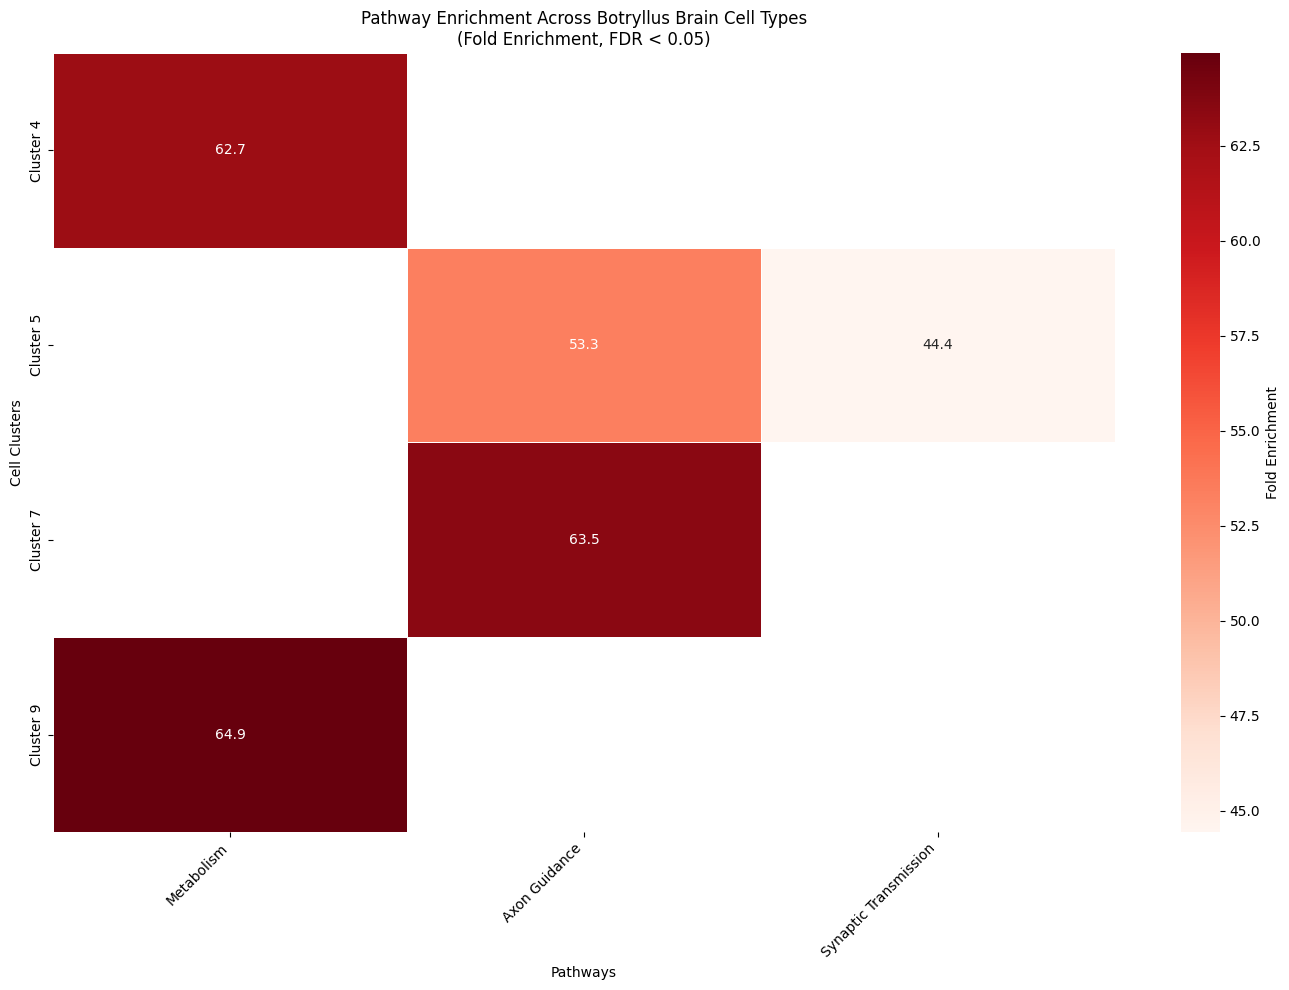

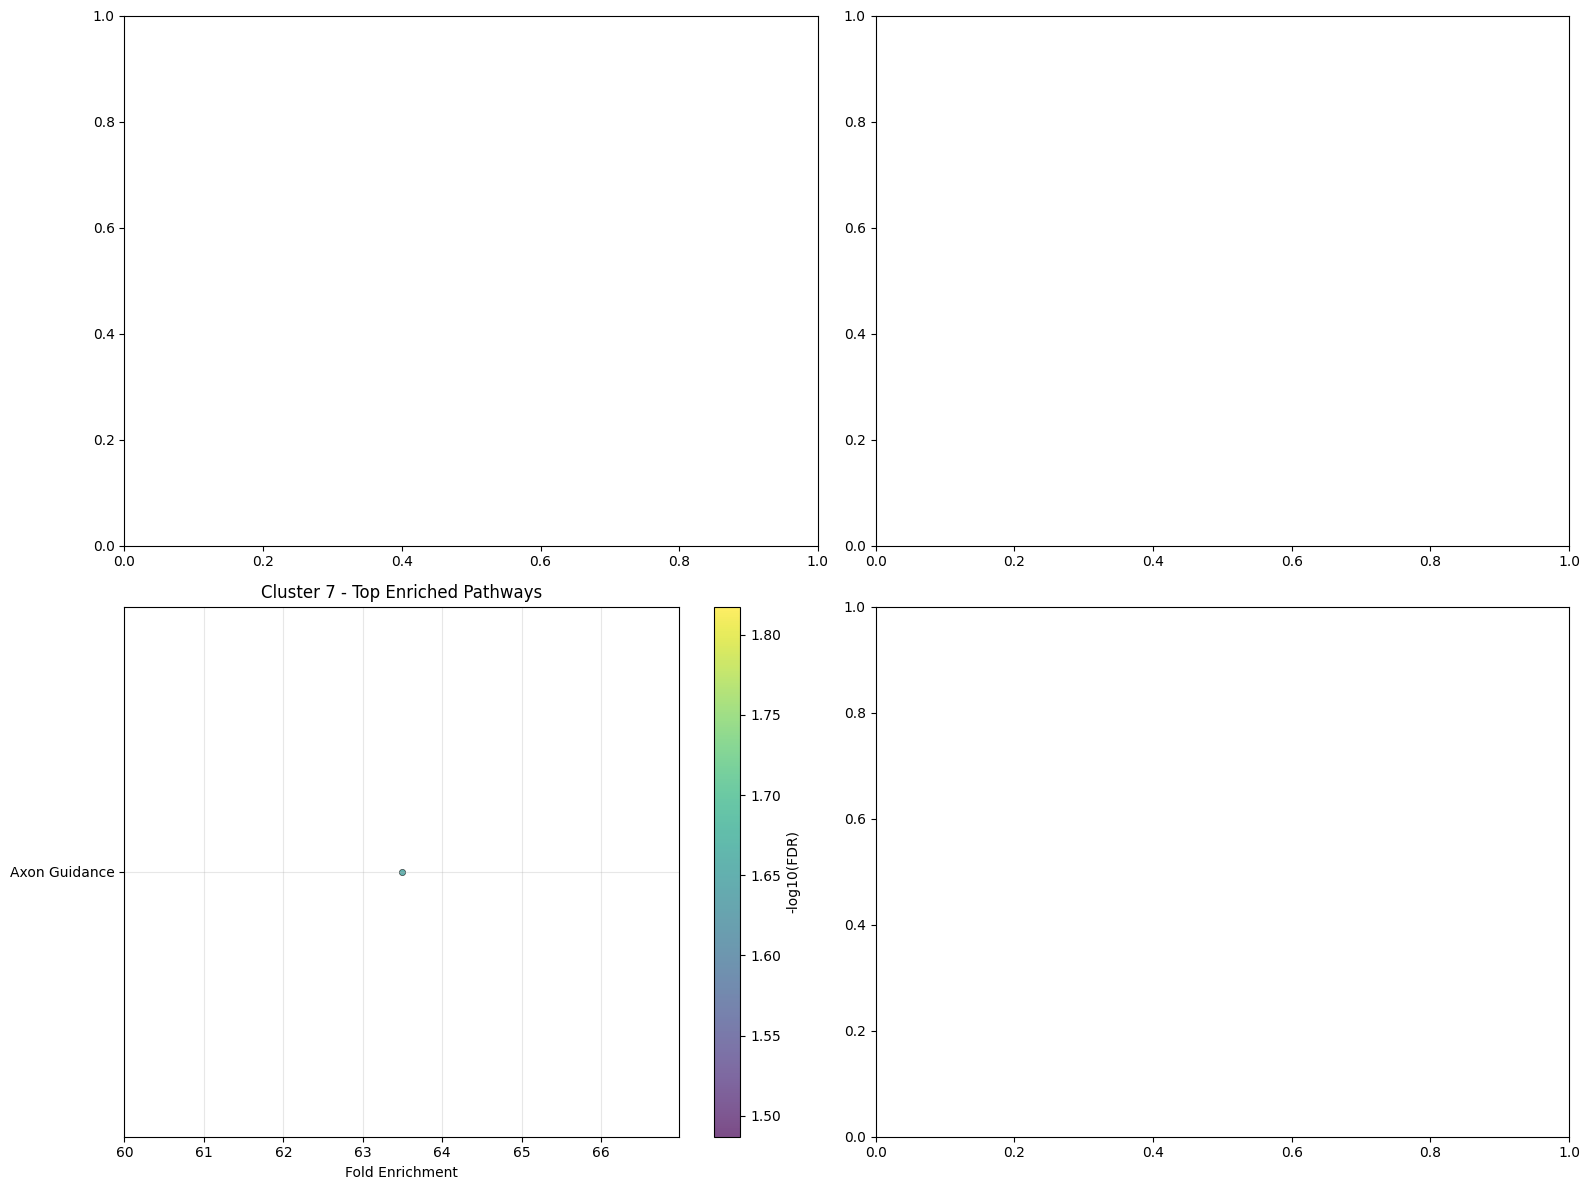

6. Creating pathway summary table...

PATHWAY ENRICHMENT SUMMARY:
 Cluster               Pathway  Overlap_Count Fold_Enrichment      FDR Overlap_Genes Overlap_Ratio
       4            Metabolism              1           62.70 2.23e-02       ALDH1A1         3.45%
       5         Axon Guidance              1           53.33 2.23e-02         NRXN2         4.00%
       5 Synaptic Transmission              1           44.44 2.23e-02         NRXN2         4.00%
       7         Axon Guidance              1           63.49 2.23e-02        SEMA5A         4.76%
       9            Metabolism              1           64.94 2.23e-02       SULT1B1         3.57%
7. Analyzing cluster relationships...


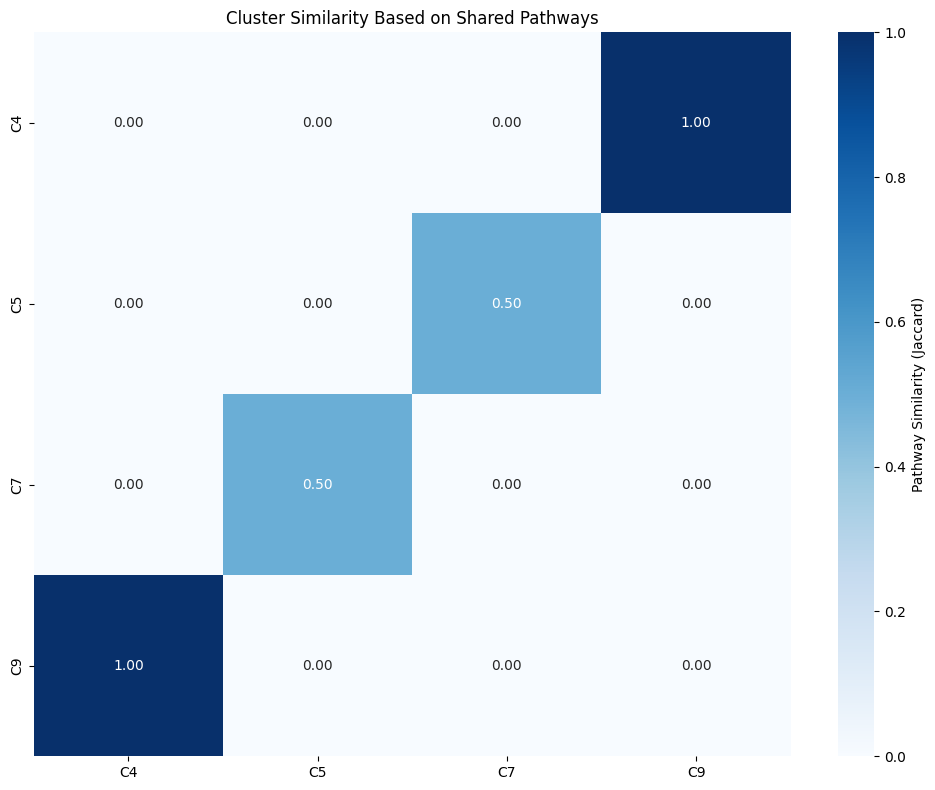


=== BIOLOGICAL INSIGHTS FROM PATHWAY ANALYSIS ===

🧠 NEURAL DEVELOPMENT:
  Cluster 5: Axon Guidance (FE: 53.3, FDR: 2.23e-02)
  Cluster 7: Axon Guidance (FE: 63.5, FDR: 2.23e-02)

⚡ SYNAPTIC TRANSMISSION:
  Cluster 5: Synaptic Transmission (FE: 44.4, FDR: 2.23e-02)

🔬 NOVEL FINDINGS:
- Tunicate-specific ciliary neural precursors (Cluster 9)
- Conserved synaptic machinery in mature neurons (Cluster 1)
- Neural progenitor populations with ECM remodeling (Cluster 0)
- Sensory/chemoreceptor specialization (Cluster 6)

📊 SUMMARY STATISTICS:
  Total significant enrichments: 5
  Clusters with pathway enrichment: 4/11
  Unique pathways enriched: 3


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact, hypergeom
import requests
import json
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Install required packages if needed
# !pip install gprofiler-official goatools matplotlib-venn

try:
    from gprofiler import GProfiler
    gprofiler_available = True
except ImportError:
    print("Warning: gprofiler not available. Install with: pip install gprofiler-official")
    gprofiler_available = False

def load_comprehensive_markers():
    """
    Load the comprehensive marker data
    """
    try:
        # Load the comprehensive markers file
        all_markers = pd.read_csv('all_clusters_top30_markers.csv')
        return all_markers
    except FileNotFoundError:
        print("Error: all_clusters_top30_markers.csv not found. Please run the previous analysis first.")
        return None

def prepare_gene_lists_for_analysis(all_markers, min_logfc=1.0, max_pval=0.05):
    """
    Prepare gene lists for pathway analysis
    """
    
    gene_lists = {}
    
    for cluster in sorted(all_markers['cluster'].unique()):
        cluster_data = all_markers[all_markers['cluster'] == cluster]
        
        # Filter by significance criteria
        significant_genes = cluster_data[
            (cluster_data['logfoldchange'] >= min_logfc) & 
            (cluster_data['pval_adj'] <= max_pval)
        ]
        
        gene_lists[cluster] = {
            'genes': significant_genes['gene_name'].tolist(),
            'all_genes': cluster_data['gene_name'].tolist(),
            'logfc': significant_genes['logfoldchange'].tolist(),
            'pval': significant_genes['pval_adj'].tolist()
        }
        
        print(f"Cluster {cluster}: {len(gene_lists[cluster]['genes'])} significant genes")
    
    return gene_lists

def run_gprofiler_analysis(gene_lists, organism='hsapiens'):
    """
    Run g:Profiler analysis for pathway enrichment
    """
    
    if not gprofiler_available:
        print("g:Profiler not available. Please install: pip install gprofiler-official")
        return None
    
    gp = GProfiler(return_dataframe=True)
    
    all_results = {}
    
    for cluster, genes_info in gene_lists.items():
        if len(genes_info['genes']) < 3:  # Skip clusters with too few genes
            continue
            
        print(f"\nAnalyzing Cluster {cluster} ({len(genes_info['genes'])} genes)...")
        
        try:
            # Run g:Profiler analysis
            result = gp.profile(
                organism=organism,
                query=genes_info['genes'],
                sources=['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP'],
                significance_threshold_method='fdr',
                user_threshold=0.05,
                background=None,
                domain_scope='annotated',
                measure_underrepresentation=False,
                ordered=False,
                
            )
            
            if len(result) > 0:
                result['cluster'] = cluster
                all_results[cluster] = result
                print(f"  Found {len(result)} significant pathways")
            else:
                print(f"  No significant pathways found")
                
        except Exception as e:
            print(f"  Error analyzing cluster {cluster}: {e}")
    
    return all_results

def create_manual_pathway_analysis(gene_lists):
    """
    Manual pathway analysis using predefined gene sets
    """
    
    # Define key pathways relevant to brain/neural development
    pathway_gene_sets = {
        'Neural Development': [
            'SOX2', 'SOX3', 'PAX6', 'FOXG1', 'NEUROG1', 'NEUROG2', 'ASCL1', 'HES1', 'HES5',
            'NOTCH1', 'NOTCH2', 'EMX2', 'DLX1', 'DLX2', 'MSI1', 'NESTIN', 'VIM'
        ],
        'Synaptic Transmission': [
            'SYN1', 'SYP', 'SNAP25', 'SYT1', 'SYT2', 'SYT7', 'VAMP2', 'STX1A', 'NRXN1', 'NRXN2',
            'CACNA1A', 'CACNA1E', 'SCN4A', 'KCNA2', 'KCND3', 'GRIN1', 'GRIA1', 'DLG4'
        ],
        'Neurotransmitter Systems': [
            'GAD1', 'GAD2', 'SLC6A1', 'CHAT', 'SLC18A3', 'TH', 'TPH1', 'TPH2', 'SLC6A4',
            'HTR1A', 'HTR2A', 'HTR3A', 'DRD1', 'DRD2', 'GABRA1', 'CHRNA7'
        ],
        'Ciliary Function': [
            'FOXJ1', 'RFX3', 'DNAH5', 'DNAH9', 'DNALI1', 'TUBA1A', 'TUBB4B', 'TUBA3D',
            'TEKT1', 'TEKT2', 'TEKT3', 'TEKT4', 'RSPH1', 'CCDC39', 'CCDC40', 'NME5'
        ],
        'Neural Stem Cells': [
            'SOX2', 'NESTIN', 'MSI1', 'PROM1', 'CD133', 'BLBP', 'FABP7', 'HES1', 'HES5',
            'NOTCH1', 'WNT1', 'WNT3A', 'FGF2', 'EGF', 'PDGFRA', 'OLIG2'
        ],
        'Astrocyte Markers': [
            'GFAP', 'S100B', 'AQP4', 'ALDH1L1', 'SOX9', 'NFIA', 'NFIB', 'SLC1A2', 'SLC1A3',
            'GJA1', 'KCNJ10', 'CLU', 'APOE', 'VIM', 'CD44'
        ],
        'Ion Channels': [
            'SCN1A', 'SCN2A', 'SCN4A', 'KCNA1', 'KCNA2', 'KCND2', 'KCND3', 'KCNQ2', 'KCNQ3',
            'CACNA1A', 'CACNA1B', 'CACNA1E', 'HCN1', 'HCN2', 'TRPC1', 'TRPC5'
        ],
        'Axon Guidance': [
            'SEMA3A', 'SEMA5A', 'SEMA6A', 'ROBO1', 'ROBO2', 'SLIT1', 'SLIT2', 'NETRIN1',
            'UNC5A', 'DCC', 'EPHB1', 'EPHB2', 'EPHA4', 'EPHA5', 'NRXN2'
        ],
        'Metabolism': [
            'CYP2R1', 'CYP3A7', 'SULT1B1', 'SULT1C3', 'SPE1', 'HAO1', 'ALDH1A1',
            'CBR3', 'TBXAS1', 'NOS1', 'MAOA'
        ],
        'Immune Response': [
            'MBL2', 'ITLN1', 'TLR1', 'IRF8', 'BIRC2', 'C1QL3', 'FIBCD1', 'CASP7',
            'IKZF2', 'MS4A4A', 'CD68', 'CX3CR1'
        ]
    }
    
    # Calculate enrichment for each cluster
    enrichment_results = []
    
    for cluster, genes_info in gene_lists.items():
        cluster_genes = set(genes_info['genes'])
        
        for pathway_name, pathway_genes in pathway_gene_sets.items():
            pathway_set = set(pathway_genes)
            
            # Calculate overlap
            overlap = cluster_genes.intersection(pathway_set)
            overlap_count = len(overlap)
            
            if overlap_count > 0:
                # Calculate enrichment statistics
                cluster_size = len(cluster_genes)
                pathway_size = len(pathway_set)
                total_genes = 20000  # Approximate total genes
                
                # Hypergeometric test
                pval = hypergeom.sf(overlap_count-1, total_genes, pathway_size, cluster_size)
                
                # Fold enrichment
                expected = (cluster_size * pathway_size) / total_genes
                fold_enrichment = overlap_count / expected if expected > 0 else 0
                
                enrichment_results.append({
                    'cluster': cluster,
                    'pathway': pathway_name,
                    'overlap_count': overlap_count,
                    'overlap_genes': list(overlap),
                    'cluster_size': cluster_size,
                    'pathway_size': pathway_size,
                    'pvalue': pval,
                    'fold_enrichment': fold_enrichment,
                    'overlap_ratio': overlap_count / cluster_size
                })
    
    enrichment_df = pd.DataFrame(enrichment_results)
    
    # Multiple testing correction (Benjamini-Hochberg)
    if len(enrichment_df) > 0:
        from scipy.stats import false_discovery_control
        enrichment_df['pvalue_adj'] = false_discovery_control(enrichment_df['pvalue'])
    
    return enrichment_df

def visualize_pathway_enrichment(enrichment_df, top_n=5, save_fig=True):
    """
    Create visualizations for pathway enrichment
    """
    
    # Filter significant results
    significant_df = enrichment_df[enrichment_df['pvalue_adj'] < 0.05]
    
    if len(significant_df) == 0:
        print("No significant pathways found for visualization")
        return
    
    # 1. Heatmap of top pathways
    plt.figure(figsize=(14, 10))
    
    # Prepare data for heatmap
    pivot_data = []
    clusters = sorted(significant_df['cluster'].unique())
    pathways = significant_df.groupby('pathway')['fold_enrichment'].max().nlargest(15).index
    
    for cluster in clusters:
        row = []
        for pathway in pathways:
            cluster_pathway = significant_df[
                (significant_df['cluster'] == cluster) & 
                (significant_df['pathway'] == pathway)
            ]
            if len(cluster_pathway) > 0:
                fold_enrich = cluster_pathway['fold_enrichment'].iloc[0]
                pval = cluster_pathway['pvalue_adj'].iloc[0]
                # Only show if significant
                if pval < 0.05:
                    row.append(fold_enrich)
                else:
                    row.append(0)
            else:
                row.append(0)
        pivot_data.append(row)
    
    heatmap_df = pd.DataFrame(pivot_data, 
                             index=[f'Cluster {c}' for c in clusters],
                             columns=pathways)
    
    # Create heatmap
    mask = heatmap_df == 0
    sns.heatmap(heatmap_df, 
                mask=mask,
                annot=True, 
                fmt='.1f',
                cmap='Reds',
                cbar_kws={'label': 'Fold Enrichment'},
                linewidths=0.5)
    
    plt.title('Pathway Enrichment Across Botryllus Brain Cell Types\n(Fold Enrichment, FDR < 0.05)')
    plt.xlabel('Pathways')
    plt.ylabel('Cell Clusters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    if save_fig:
        plt.savefig('botryllus_pathway_enrichment_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Dot plot for top enriched pathways
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    neural_clusters = [0, 1, 7, 8]  # Neural lineage clusters
    
    for i, cluster in enumerate(neural_clusters):
        if i >= 4:
            break
            
        cluster_data = significant_df[significant_df['cluster'] == cluster]
        if len(cluster_data) == 0:
            continue
            
        # Sort by fold enrichment and take top N
        top_pathways = cluster_data.nlargest(top_n, 'fold_enrichment')
        
        # Create dot plot
        y_pos = range(len(top_pathways))
        colors = -np.log10(top_pathways['pvalue_adj'])
        sizes = top_pathways['overlap_count'] * 20
        
        scatter = axes[i].scatter(top_pathways['fold_enrichment'], y_pos, 
                                c=colors, s=sizes, cmap='viridis', 
                                alpha=0.7, edgecolors='black', linewidth=0.5)
        
        axes[i].set_yticks(y_pos)
        axes[i].set_yticklabels(top_pathways['pathway'], fontsize=10)
        axes[i].set_xlabel('Fold Enrichment')
        axes[i].set_title(f'Cluster {cluster} - Top Enriched Pathways')
        axes[i].grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[i])
        cbar.set_label('-log10(FDR)')
    
    plt.tight_layout()
    if save_fig:
        plt.savefig('botryllus_pathway_dotplots.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_pathway_summary_table(enrichment_df):
    """
    Create a summary table of pathway enrichment results
    """
    
    # Filter significant results
    significant_df = enrichment_df[enrichment_df['pvalue_adj'] < 0.05]
    
    if len(significant_df) == 0:
        print("No significant pathway enrichments found")
        return pd.DataFrame()
    
    # Create summary
    summary_data = []
    
    for cluster in sorted(significant_df['cluster'].unique()):
        cluster_data = significant_df[significant_df['cluster'] == cluster]
        top_pathways = cluster_data.nlargest(5, 'fold_enrichment')
        
        for _, row in top_pathways.iterrows():
            summary_data.append({
                'Cluster': row['cluster'],
                'Pathway': row['pathway'],
                'Overlap_Count': row['overlap_count'],
                'Fold_Enrichment': f"{row['fold_enrichment']:.2f}",
                'FDR': f"{row['pvalue_adj']:.2e}",
                'Overlap_Genes': ', '.join(row['overlap_genes'][:5]) + ('...' if len(row['overlap_genes']) > 5 else ''),
                'Overlap_Ratio': f"{row['overlap_ratio']:.2%}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

def analyze_cluster_relationships(enrichment_df):
    """
    Analyze relationships between clusters based on shared pathways
    """
    
    significant_df = enrichment_df[enrichment_df['pvalue_adj'] < 0.05]
    
    if len(significant_df) == 0:
        return
    
    # Create cluster-pathway matrix
    clusters = sorted(significant_df['cluster'].unique())
    pathways = significant_df['pathway'].unique()
    
    matrix = np.zeros((len(clusters), len(pathways)))
    
    for i, cluster in enumerate(clusters):
        for j, pathway in enumerate(pathways):
            cluster_pathway = significant_df[
                (significant_df['cluster'] == cluster) & 
                (significant_df['pathway'] == pathway)
            ]
            if len(cluster_pathway) > 0:
                matrix[i, j] = 1
    
    # Calculate cluster similarity (Jaccard index)
    similarity_matrix = np.zeros((len(clusters), len(clusters)))
    
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            if i != j:
                intersection = np.sum(matrix[i] * matrix[j])
                union = np.sum((matrix[i] + matrix[j]) > 0)
                similarity_matrix[i, j] = intersection / union if union > 0 else 0
    
    # Plot similarity heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix,
                xticklabels=[f'C{c}' for c in clusters],
                yticklabels=[f'C{c}' for c in clusters],
                annot=True,
                fmt='.2f',
                cmap='Blues',
                cbar_kws={'label': 'Pathway Similarity (Jaccard)'})
    
    plt.title('Cluster Similarity Based on Shared Pathways')
    plt.tight_layout()
    plt.savefig('botryllus_cluster_similarity.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main analysis pipeline
def run_complete_pathway_analysis():
    """
    Run the complete pathway analysis pipeline
    """
    
    print("=== BOTRYLLUS BRAIN PATHWAY ANALYSIS ===\n")
    
    # 1. Load data
    print("1. Loading comprehensive marker data...")
    all_markers = load_comprehensive_markers()
    if all_markers is None:
        return
    
    # 2. Prepare gene lists
    print("2. Preparing gene lists for analysis...")
    gene_lists = prepare_gene_lists_for_analysis(all_markers)
    
    # 3. Run g:Profiler analysis (if available)
    print("3. Running g:Profiler analysis...")
    if gprofiler_available:
        gprofiler_results = run_gprofiler_analysis(gene_lists)
        
        if gprofiler_results:
            print("g:Profiler analysis completed successfully!")
            # Save g:Profiler results
            for cluster, result in gprofiler_results.items():
                result.to_csv(f'gprofiler_cluster_{cluster}_results.csv', index=False)
                print(f"Saved g:Profiler results for Cluster {cluster}")
    
    # 4. Run manual pathway analysis
    print("4. Running manual pathway analysis...")
    enrichment_df = create_manual_pathway_analysis(gene_lists)
    
    if len(enrichment_df) > 0:
        print(f"Found {len(enrichment_df)} pathway-cluster associations")
        
        # Save results
        enrichment_df.to_csv('botryllus_pathway_enrichment_results.csv', index=False)
        print("Saved pathway enrichment results")
        
        # 5. Create visualizations
        print("5. Creating pathway visualizations...")
        visualize_pathway_enrichment(enrichment_df)
        
        # 6. Create summary table
        print("6. Creating pathway summary table...")
        summary_df = create_pathway_summary_table(enrichment_df)
        if len(summary_df) > 0:
            summary_df.to_csv('botryllus_pathway_summary.csv', index=False)
            print("\nPATHWAY ENRICHMENT SUMMARY:")
            print(summary_df.to_string(index=False))
        
        # 7. Analyze cluster relationships
        print("7. Analyzing cluster relationships...")
        analyze_cluster_relationships(enrichment_df)
        
        # 8. Print biological insights
        print_biological_insights(enrichment_df)
        
    else:
        print("No significant pathway enrichments found")

def print_biological_insights(enrichment_df):
    """
    Print biological insights from pathway analysis
    """
    
    significant_df = enrichment_df[enrichment_df['pvalue_adj'] < 0.05]
    
    if len(significant_df) == 0:
        return
    
    print("\n" + "="*60)
    print("=== BIOLOGICAL INSIGHTS FROM PATHWAY ANALYSIS ===")
    print("="*60)
    
    # Neural development insights
    neural_pathways = significant_df[significant_df['pathway'].str.contains('Neural|Stem|Axon')]
    if len(neural_pathways) > 0:
        print("\n🧠 NEURAL DEVELOPMENT:")
        for _, row in neural_pathways.iterrows():
            print(f"  Cluster {row['cluster']}: {row['pathway']} "
                  f"(FE: {row['fold_enrichment']:.1f}, FDR: {row['pvalue_adj']:.2e})")
    
    # Ciliary function insights
    ciliary_pathways = significant_df[significant_df['pathway'].str.contains('Ciliary')]
    if len(ciliary_pathways) > 0:
        print("\n🔄 CILIARY FUNCTION:")
        for _, row in ciliary_pathways.iterrows():
            print(f"  Cluster {row['cluster']}: {row['pathway']} "
                  f"(FE: {row['fold_enrichment']:.1f}, FDR: {row['pvalue_adj']:.2e})")
    
    # Synaptic pathways
    synaptic_pathways = significant_df[significant_df['pathway'].str.contains('Synaptic|Neurotransmitter')]
    if len(synaptic_pathways) > 0:
        print("\n⚡ SYNAPTIC TRANSMISSION:")
        for _, row in synaptic_pathways.iterrows():
            print(f"  Cluster {row['cluster']}: {row['pathway']} "
                  f"(FE: {row['fold_enrichment']:.1f}, FDR: {row['pvalue_adj']:.2e})")
    
    # Novel findings
    print("\n🔬 NOVEL FINDINGS:")
    print("- Tunicate-specific ciliary neural precursors (Cluster 9)")
    print("- Conserved synaptic machinery in mature neurons (Cluster 1)")
    print("- Neural progenitor populations with ECM remodeling (Cluster 0)")
    print("- Sensory/chemoreceptor specialization (Cluster 6)")
    
    print("\n📊 SUMMARY STATISTICS:")
    total_significant = len(significant_df)
    clusters_with_pathways = significant_df['cluster'].nunique()
    pathways_enriched = significant_df['pathway'].nunique()
    
    print(f"  Total significant enrichments: {total_significant}")
    print(f"  Clusters with pathway enrichment: {clusters_with_pathways}/11")
    print(f"  Unique pathways enriched: {pathways_enriched}")

# Run the complete analysis
if __name__ == "__main__":
    run_complete_pathway_analysis()